In [7]:
R.version

               _                                
platform       x86_64-w64-mingw32               
arch           x86_64                           
os             mingw32                          
crt            ucrt                             
system         x86_64, mingw32                  
status                                          
major          4                                
minor          4.2                              
year           2024                             
month          10                               
day            31                               
svn rev        87279                            
language       R                                
version.string R version 4.4.2 (2024-10-31 ucrt)
nickname       Pile of Leaves                   

# 1. Initialization

In [10]:
# PACKAGES & CONSTANTS DECLARATIONS #
#####################################

# Function to install missing packages
InstallPackages <- function(oPackageList) {
  for (sPackage in oPackageList) {
    if (!require(sPackage, character.only = TRUE)) {
      install.packages(sPackage, repos = "http://cran.r-project.org")
      library(sPackage, character.only = TRUE)
    }
  }
}

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

# List of required packages
oRequiredPackages <- c("sfsmisc","sparsepca", "elasticnet","reshape2", "ggplot2", "tidyr", "dplyr", "MASS", "Matrix", "stats", "doParallel")

# Install missing packages
InstallPackages(oRequiredPackages)

global_iRandomSeed <- 13654
set.seed(global_iRandomSeed)  # for reproducibility

# Constants for data dimensions
N_OBSERVATIONS <- 1000
N_VARIABLES <- 2000
global_UseParallelization = 1
global_bZeroImputationBehaviour = 1
global_TrainTestRatio = 0.7

# If needed, enable CPU cores parallelization #
if (global_UseParallelization == 1) {
    library(doParallel)
    global_iCoreNumber <- detectCores() - 1
    registerDoParallel(cores = global_iCoreNumber)
}

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Duration :", elapsed_time, "seconds"))

[1] "Current Time : 2024-12-04 16:03:14"


Le chargement a nécessité le package : sfsmisc

Le chargement a nécessité le package : sparsepca

Le chargement a nécessité le package : elasticnet

Le chargement a nécessité le package : lars

Loaded lars 1.3


Registered S3 method overwritten by 'elasticnet':
  method     from     
  print.spca sparsepca


Attachement du package : 'elasticnet'


L'objet suivant est masqué depuis 'package:sparsepca':

    spca


Le chargement a nécessité le package : reshape2

Le chargement a nécessité le package : ggplot2

Le chargement a nécessité le package : tidyr


Attachement du package : 'tidyr'


L'objet suivant est masqué depuis 'package:reshape2':

    smiths


Le chargement a nécessité le package : dplyr


Attachement du package : 'dplyr'


L'objet suivant est masqué depuis 'package:sfsmisc':

    last


L'objet suivant est masqué depuis 'package:Biobase':

    combine


Les objets suivants sont masqués depuis 'package:BiocGenerics':

    combine, intersect, setdiff, union


Les objets suiv

[1] "Current Time : 2024-12-04 16:03:15"
[1] "Duration : 0.712 seconds"


# 2. Data Generation

In [13]:
Get_Preprocessed_Data <- function(oDataSet) {
  Get_the_Mode <- function(x) {
    ux <- unique(na.omit(x))
    ux[which.max(tabulate(match(x, ux)))]
  }

  if (global_bZeroImputationBehaviour == 1) {
      oDataSet <- oDataSet %>%
        mutate(across(where(is.numeric), ~ if_else((is.na(.) | (. == 0)), mean(., na.rm = TRUE), .)))
  } else if (global_bZeroImputationBehaviour == 0) {    
      oDataSet <- oDataSet %>%
        mutate(across(where(is.numeric), ~ if_else(is.na(.), mean(., na.rm = TRUE), .)))
  }

  # Replace NA by the mode.
  oDataSet <- oDataSet %>%
    mutate(across(where(is.factor), ~ if_else(is.na(.), Get_the_Mode(.), .)))

  return(oDataSet)
}

In [23]:
# DATASET 03 => Breast Cancer                  #
################################################

# Based on thos article : https://www.bioconductor.org/packages/devel/bioc/vignettes/PCAtools/inst/doc/PCAtools.html#download-the-package-from-bioconductor

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

if (!requireNamespace("BiocManager", quietly = TRUE)) {
    install.packages("BiocManager")
}
BiocManager::install(c("Biobase", "GEOquery"))

library(Biobase)
library(GEOquery)

# Loading data from GEO
gset <- getGEO('GSE2990', GSEMatrix = TRUE, getGPL = FALSE)

# Extraction de la matrice d'expression
mat <- exprs(gset[[1]])

# Cleaning Affymetrix probes
mat <- mat[-grep('^AFFX', rownames(mat)),]

# Extraction metadata
idx <- which(colnames(pData(gset[[1]])) %in%
    c('relation', 'age:ch1', 'distant rfs:ch1', 'er:ch1',
      'ggi:ch1', 'grade:ch1', 'size:ch1',
      'time rfs:ch1'))
metadata <- data.frame(pData(gset[[1]])[, idx],
                       row.names = rownames(pData(gset[[1]])))

colnames(metadata) <- c('Study', 'Age', 'Distant.RFS', 'ER', 'GGI', 'Grade',
                        'Size', 'Time.RFS')

metadata$Study <- gsub('Reanalyzed by: ', '', as.character(metadata$Study))
metadata$Age <- as.numeric(gsub('^KJ', NA, as.character(metadata$Age)))
metadata$Distant.RFS <- factor(metadata$Distant.RFS, levels = c(0, 1))
metadata$ER <- factor(gsub('\\?', NA, as.character(metadata$ER)),
                      levels = c(0, 1))
metadata$ER <- factor(ifelse(metadata$ER == 1, 'ER+', 'ER-'),
                      levels = c('ER-', 'ER+'))
metadata$GGI <- as.numeric(as.character(metadata$GGI))
metadata$Grade <- factor(gsub('\\?', NA, as.character(metadata$Grade)),
                         levels = c(1, 2, 3))
metadata$Grade <- gsub(1, 'Grade 1', gsub(2, 'Grade 2', gsub(3, 'Grade 3', metadata$Grade)))
metadata$Grade <- factor(metadata$Grade, levels = c('Grade 1', 'Grade 2', 'Grade 3'))
metadata$Size <- as.numeric(as.character(metadata$Size))
metadata$Time.RFS <- as.numeric(gsub('^KJX|^KJ', NA, metadata$Time.RFS))

discard <- apply(metadata, 1, function(x) any(is.na(x)))
metadata <- metadata[!discard,]

mat <- mat[, which(colnames(mat) %in% rownames(metadata))]

if (!all(colnames(mat) == rownames(metadata))) {
    stop("Les noms des échantillons ne correspondent pas exactement entre les métadonnées et la matrice d'expression.")
}

oDataMatrix <- as.data.frame(mat)

if (!is.null(oDataMatrix)) {
  oDataMatrix <- oDataMatrix[, sapply(oDataMatrix, is.numeric), drop = FALSE]
  oDataMatrix <- as.data.frame(lapply(oDataMatrix, as.double))
  oDataMatrix <- as.data.frame(lapply(oDataMatrix, function(col) as.numeric(as.character(col))))
  if (any(is.na(oDataMatrix))) {
    warning("NA detected after conversion. Rows with NA will be removed.")
    oDataMatrix <- na.omit(oDataMatrix)
  }
} else {
  stop("oDataMatrix is NULL. Please provide a valid dataset.")
}

oDataMatrix <- as.matrix(oDataMatrix)

cat("Dimensions Matrix : ", dim(mat), "\n")

# Preprocessing
oDataMatrix <- Get_Preprocessed_Data(oDataMatrix)

head(oDataMatrix)

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Duration :", elapsed_time, "seconds"))

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.2 (2024-10-31 ucrt)

Warning message:
"package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'Biobase' 'GEOquery'"
Old packages: 'bit', 'later', 'promises', 'quantreg'

Found 1 file(s)

GSE2990_series_matrix.txt.gz

Using locally cached version: C:\Users\gouro\AppData\Local\Temp\Rtmpie4XYp/GSE2990_series_matrix.txt.gz



Dimensions de la matrice prétraitée :  22215 91 


GSM65752,GSM65753,GSM65755,GSM65757,GSM65758,GSM65760,GSM65761,GSM65762,GSM65763,GSM65764,⋯,GSM65868,GSM65869,GSM65870,GSM65871,GSM65872,GSM65873,GSM65874,GSM65875,GSM65878,GSM65880
11.417945,11.466307,10.843553,11.705501,10.869301,11.065947,11.960048,11.507803,11.001594,10.288300,⋯,11.339789,11.700093,11.173078,11.321648,11.238857,10.972367,11.226179,11.765416,11.537388,11.525479
7.379692,6.915186,7.369199,7.071089,6.910977,6.776827,7.044657,6.695045,6.684117,6.915896,⋯,7.554001,7.670501,7.362108,6.951810,7.264888,7.291469,6.934923,6.938407,7.147455,7.130340
7.993892,7.316317,7.234621,7.489355,7.634307,7.256335,7.242439,7.313722,7.802289,7.178194,⋯,8.095860,7.390571,7.090128,7.097622,7.096999,7.454182,6.927617,7.112679,7.548334,7.506661
9.358754,9.179772,9.242987,9.281594,9.304971,9.518042,9.353926,9.208027,9.276619,9.395631,⋯,9.700273,9.876940,9.803706,9.832048,9.829909,9.918604,9.668749,10.358743,9.775151,9.963190
4.532913,4.447458,4.419171,4.363968,4.366959,4.619477,4.512231,4.443399,4.494221,4.438276,⋯,5.120697,5.055644,4.991288,5.122737,5.081239,5.171156,5.084063,5.174404,4.958959,5.018631
7.647977,8.534378,7.606492,8.227871,8.582203,8.709101,9.043281,8.279555,8.559933,8.672444,⋯,7.899592,8.373722,8.649969,8.258050,8.860578,8.466948,8.373746,9.148830,8.152121,8.290546


Dimensions de la matrice d'expression :  22215 91 
Dimensions des métadonnées :  91 8 


ERROR: Error in UseMethod("mutate"): pas de méthode pour 'mutate' applicable pour un objet de classe "c('matrix', 'array', 'double', 'numeric')"


# 3. Data Exploration

In [28]:
# Define train and test sets             #
##########################################

iTrainIndices <- sample(1:nrow(oDataMatrix), size = global_TrainTestRatio * nrow(oDataMatrix))
oTrainData <- oDataMatrix[iTrainIndices, ]
oTestData <- oDataMatrix[-iTrainIndices, ]  # Remaining data for testing

In [67]:
dim(oDataMatrix)
dim(oTrainData)
dim(oTestData)

cat("Colunms : ", colnames(oDataMatrix), "\n")

[1] 22215    91

[1] 15550    91

[1] 6665   91

Colunms :  GSM65752 GSM65753 GSM65755 GSM65757 GSM65758 GSM65760 GSM65761 GSM65762 GSM65763 GSM65764 GSM65767 GSM65768 GSM65769 GSM65770 GSM65771 GSM65772 GSM65773 GSM65774 GSM65775 GSM65776 GSM65779 GSM65781 GSM65783 GSM65784 GSM65785 GSM65786 GSM65788 GSM65789 GSM65790 GSM65791 GSM65792 GSM65793 GSM65794 GSM65795 GSM65796 GSM65797 GSM65798 GSM65799 GSM65800 GSM65801 GSM65803 GSM65804 GSM65805 GSM65806 GSM65807 GSM65808 GSM65811 GSM65814 GSM65815 GSM65816 GSM65817 GSM65818 GSM65819 GSM65821 GSM65822 GSM65824 GSM65830 GSM65831 GSM65832 GSM65833 GSM65834 GSM65836 GSM65837 GSM65839 GSM65841 GSM65842 GSM65843 GSM65844 GSM65845 GSM65848 GSM65850 GSM65853 GSM65855 GSM65857 GSM65860 GSM65861 GSM65862 GSM65863 GSM65865 GSM65866 GSM65867 GSM65868 GSM65869 GSM65870 GSM65871 GSM65872 GSM65873 GSM65874 GSM65875 GSM65878 GSM65880 


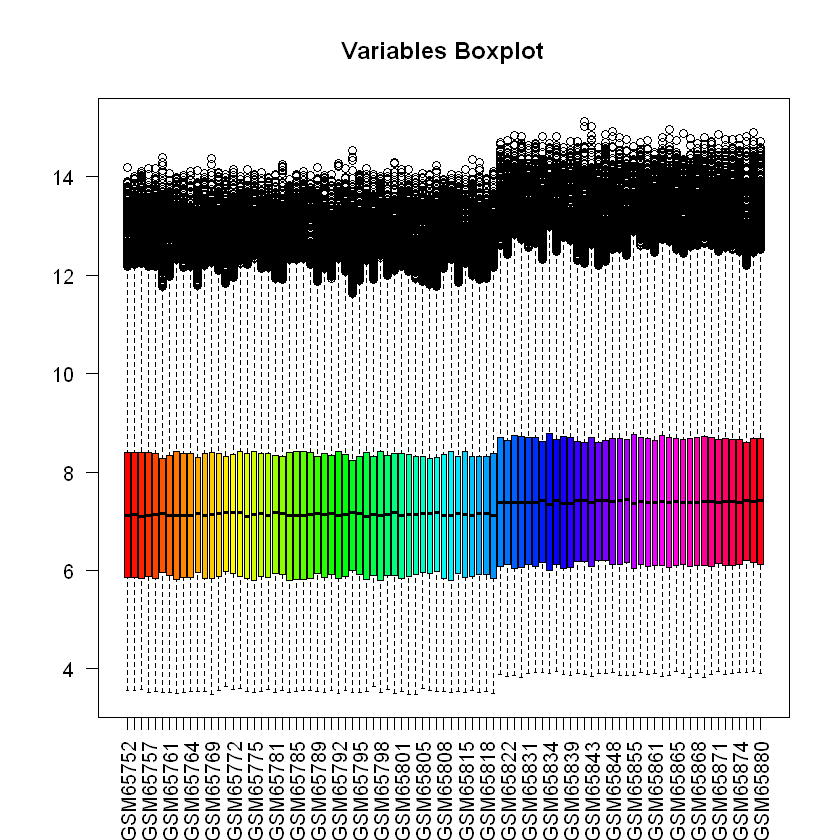

In [71]:
boxplot(oDataMatrix, las = 2, col = rainbow(ncol(oDataMatrix)), main = "Variables Boxplot")

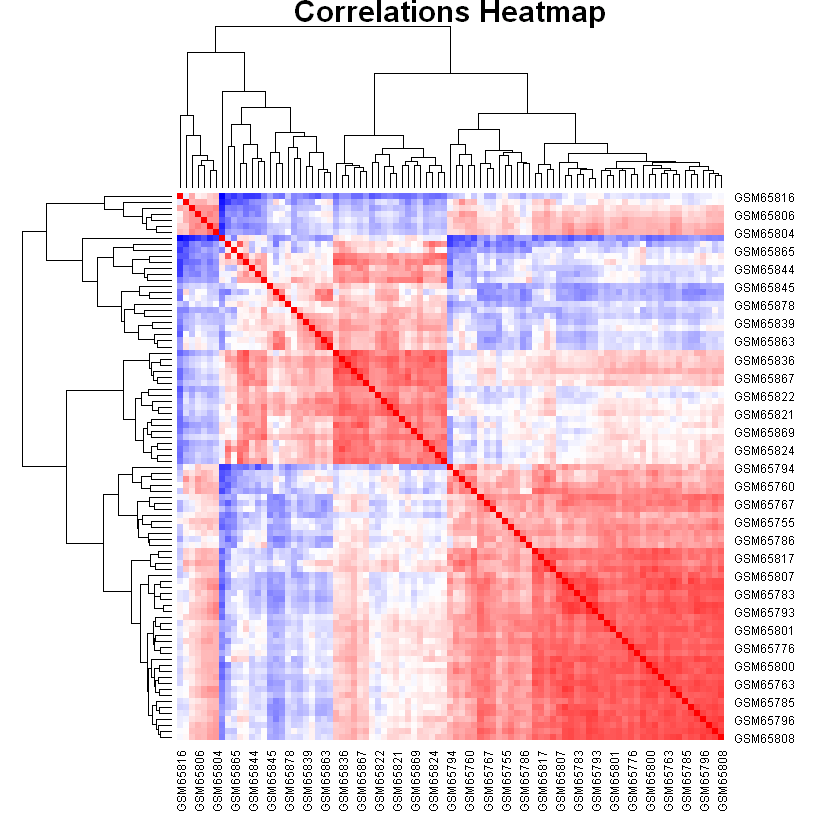

In [75]:
##########################################
# Correlation Matrix                     #
##########################################

cor_matrix <- cor(oDataMatrix)

# Correlations Heatmap
heatmap(cor_matrix, symm = TRUE, col = colorRampPalette(c("blue", "white", "red"))(100),
        main = "Correlations Heatmap")

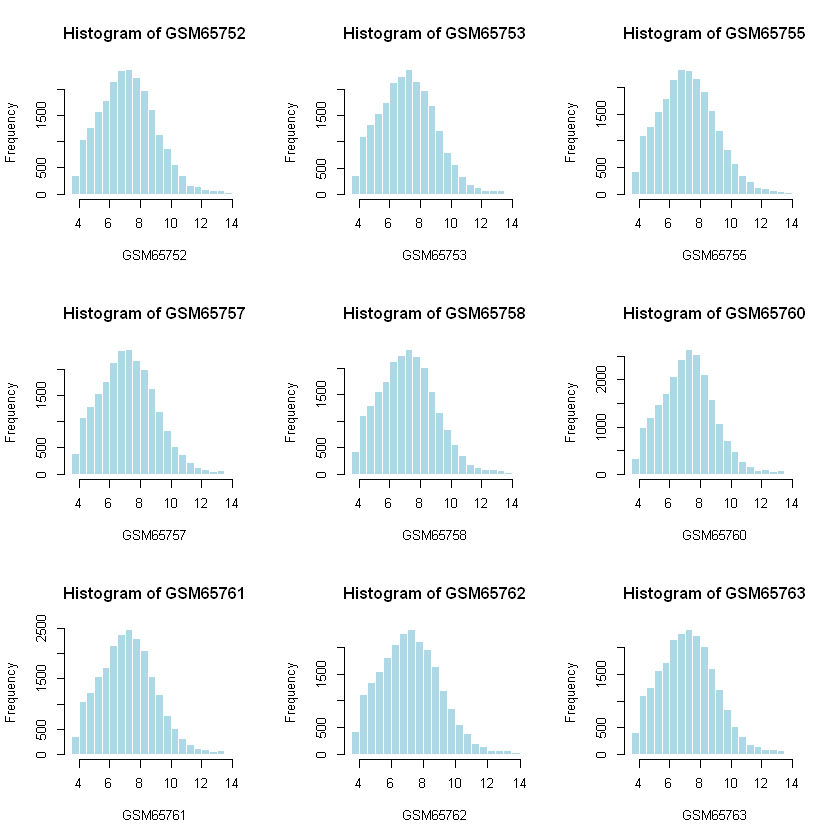

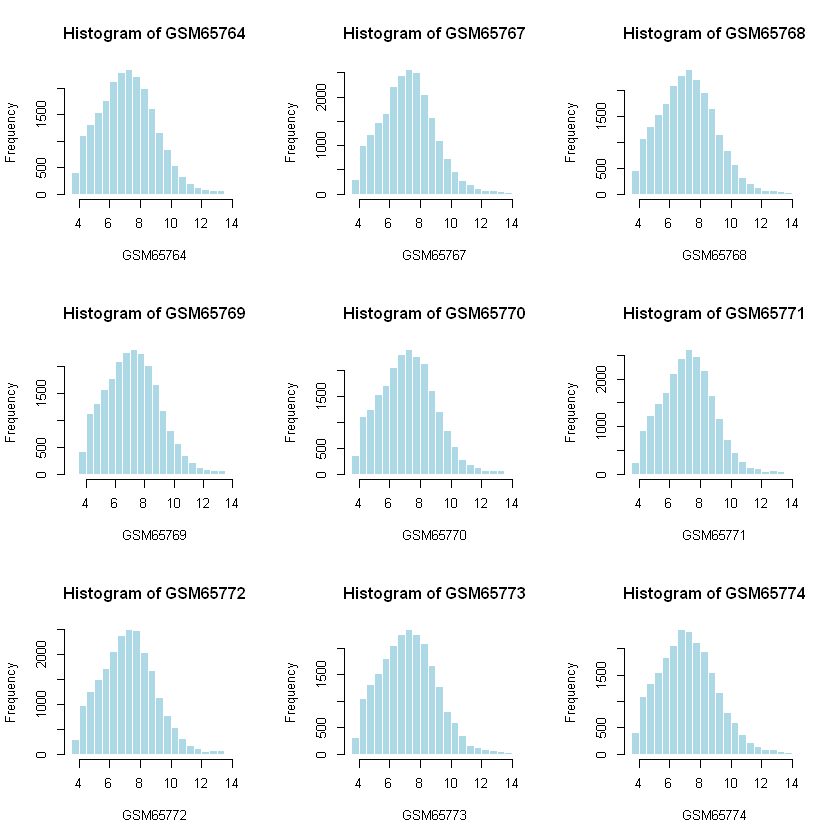

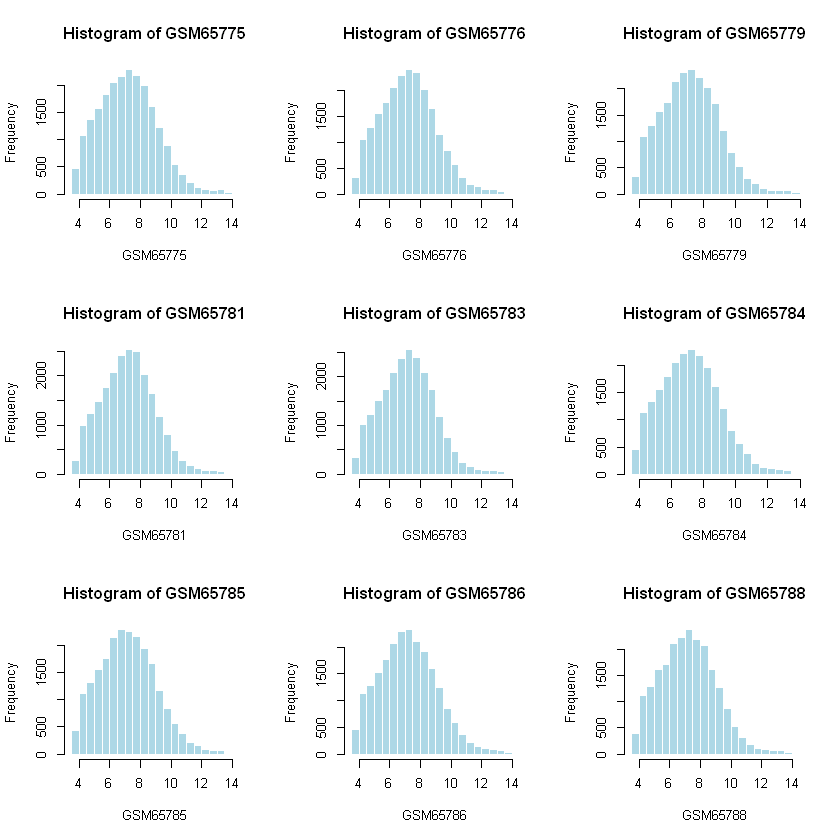

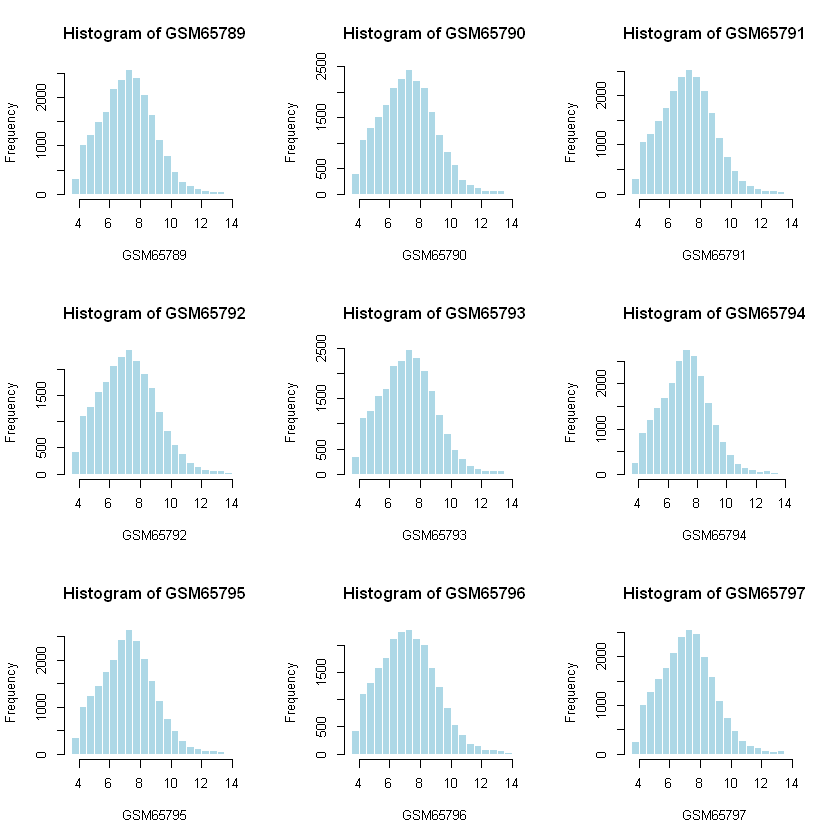

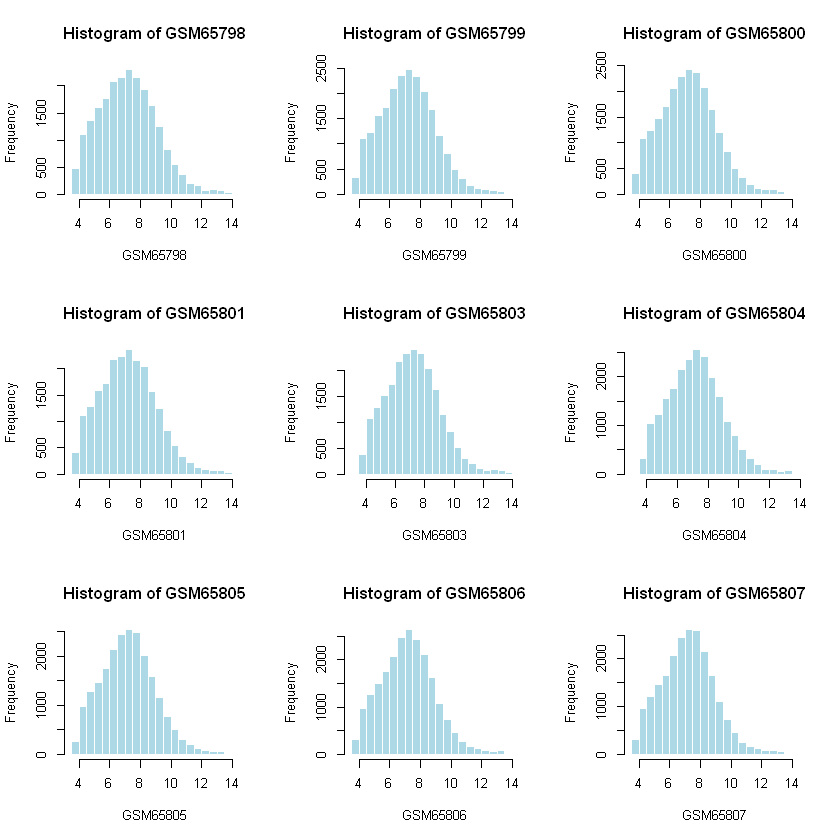

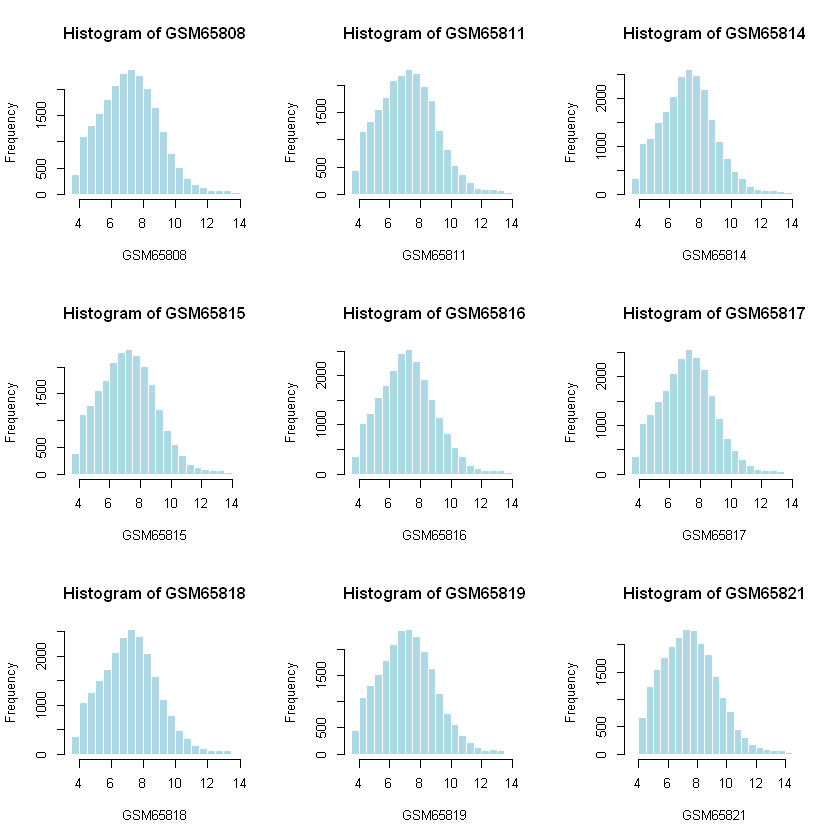

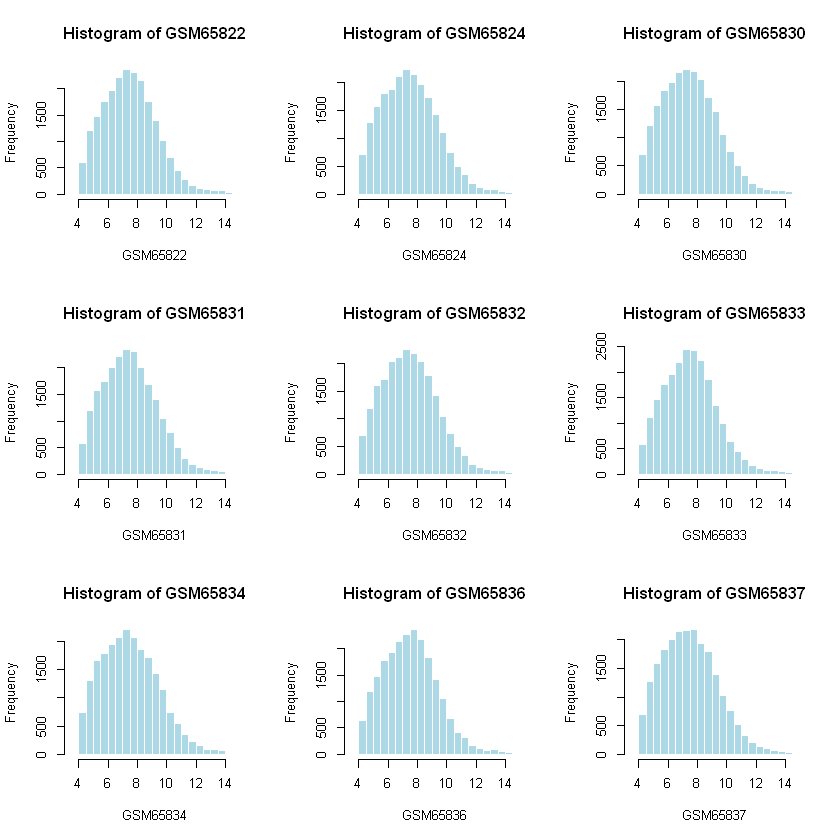

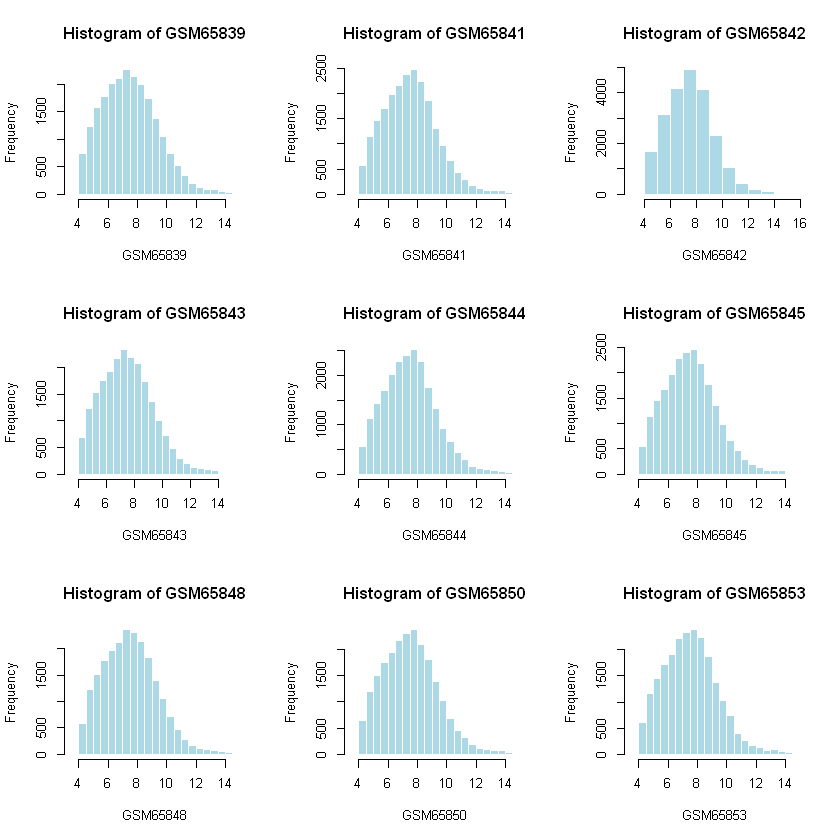

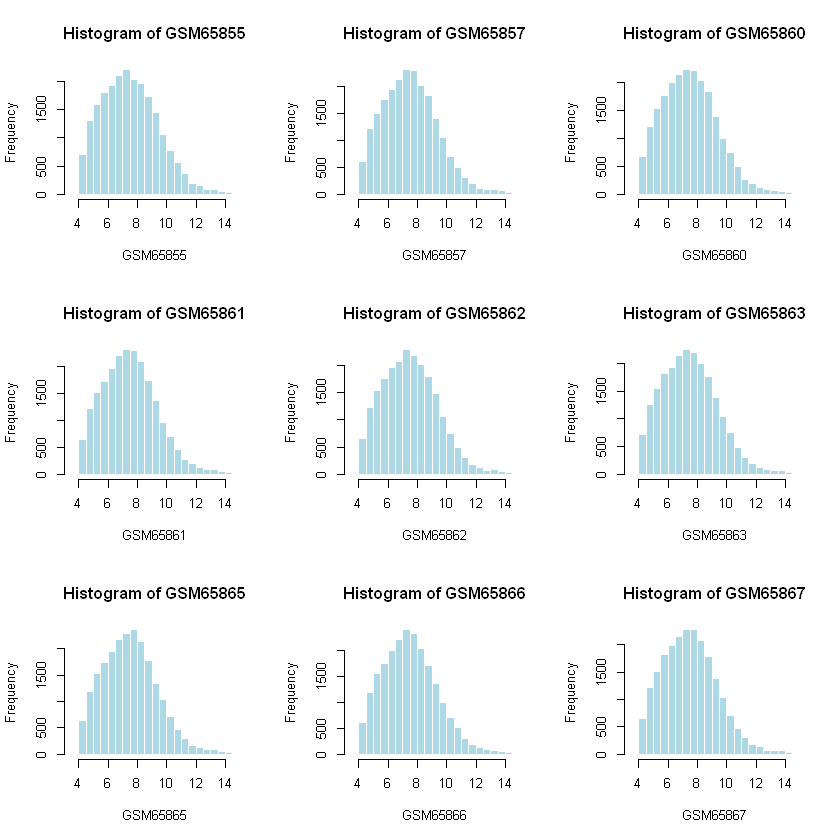

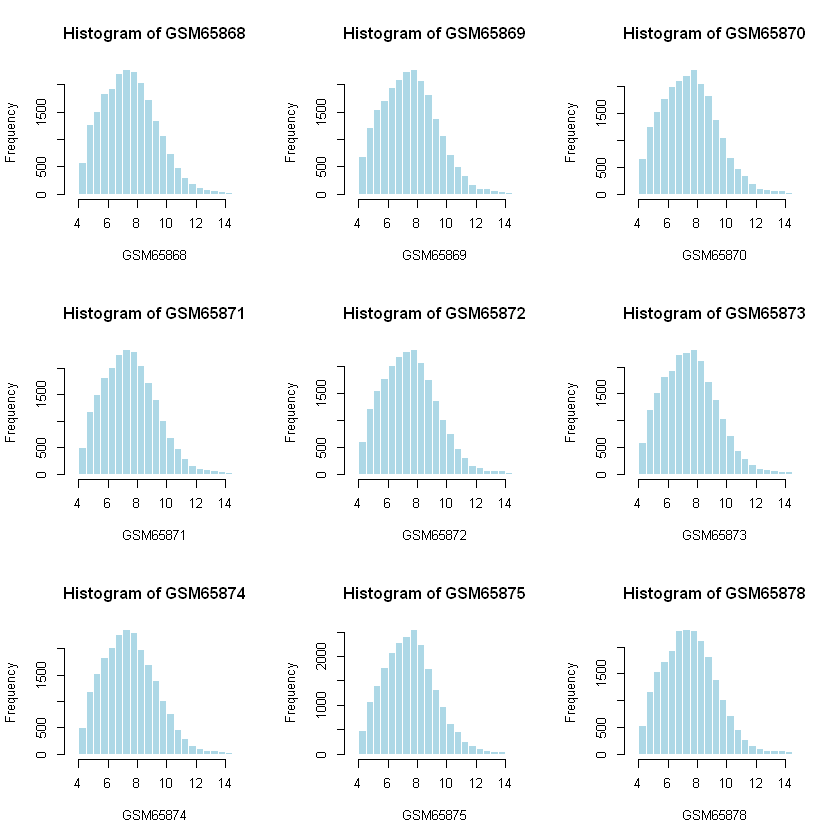

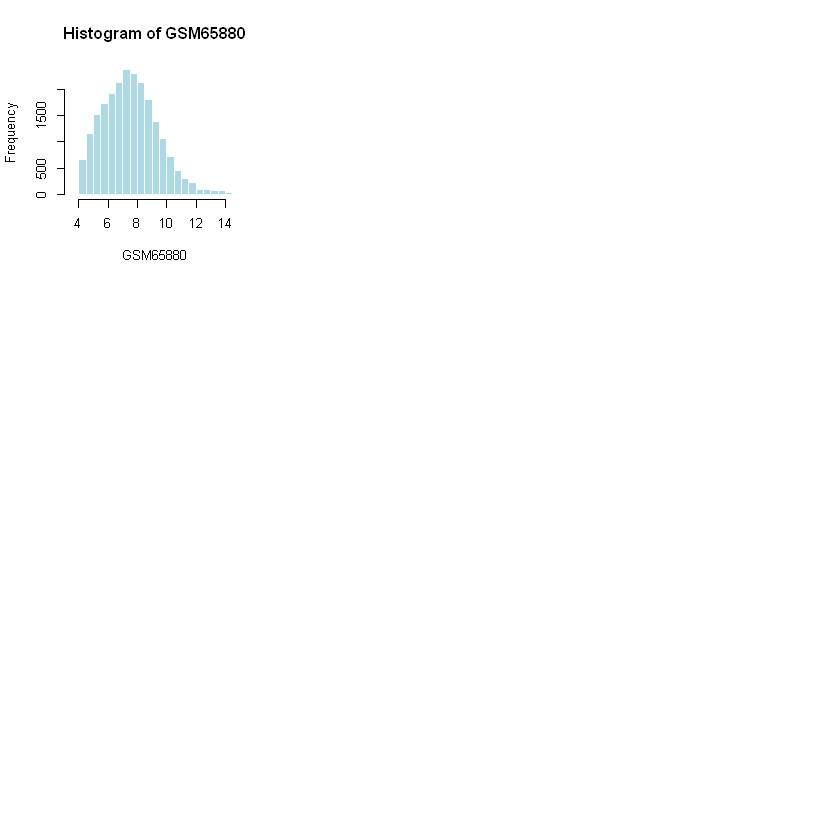

In [77]:
##########################################
# Histograms for each variable           #
##########################################

par(mfrow = c(3, 3))  # Arrange plots in a grid
for (col in colnames(oDataMatrix)) {
    hist(oDataMatrix[, col], main = paste("Histogram of", col), xlab = col, col = "lightblue", border = "white")
}
par(mfrow = c(1, 1))  # Reset plot layout


Importance of components:
                          PC1     PC2     PC3     PC4     PC5    PC6     PC7
Standard deviation     9.2088 1.28131 0.80634 0.57292 0.53814 0.4575 0.41780
Proportion of Variance 0.9319 0.01804 0.00714 0.00361 0.00318 0.0023 0.00192
Cumulative Proportion  0.9319 0.94993 0.95707 0.96068 0.96386 0.9662 0.96808
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     0.40212 0.35066 0.34893 0.33340 0.32034 0.27701 0.27260
Proportion of Variance 0.00178 0.00135 0.00134 0.00122 0.00113 0.00084 0.00082
Cumulative Proportion  0.96986 0.97121 0.97255 0.97377 0.97490 0.97574 0.97656
                         PC15    PC16    PC17    PC18    PC19    PC20    PC21
Standard deviation     0.2704 0.26138 0.25058 0.24613 0.24117 0.23510 0.22968
Proportion of Variance 0.0008 0.00075 0.00069 0.00067 0.00064 0.00061 0.00058
Cumulative Proportion  0.9774 0.97811 0.97880 0.97947 0.98010 0.98071 0.98129
                          PC22    PC23

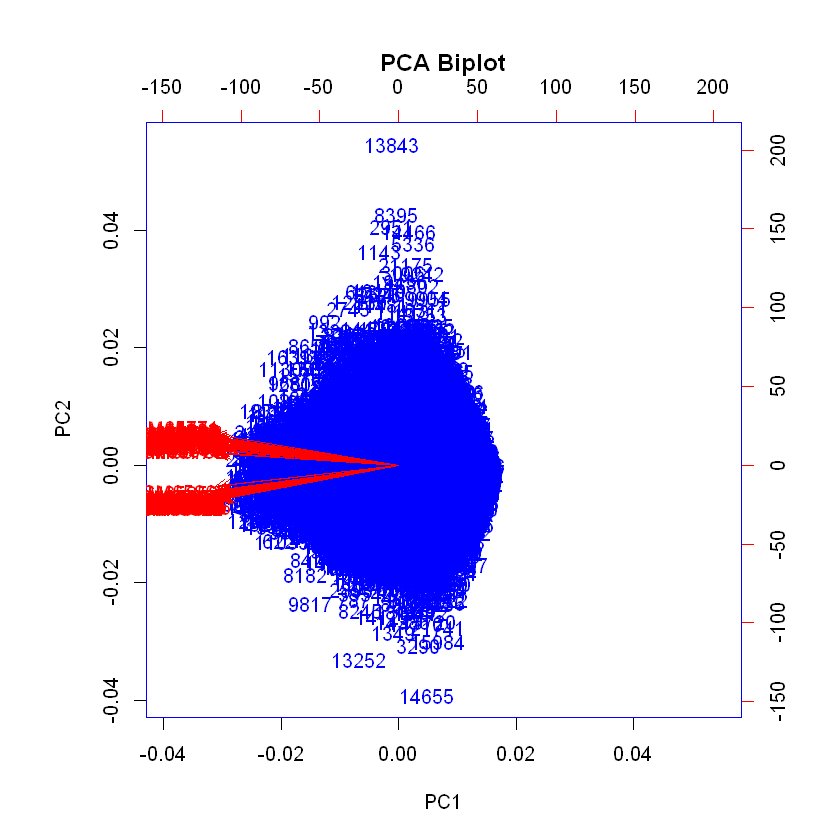

In [79]:
##########################################
# PCA Simple                             #
##########################################

pca_res <- prcomp(oDataMatrix, center = TRUE, scale. = TRUE)

# Summary of principal components
summary(pca_res)

# Biplot of the first two principal components
biplot(pca_res, main = "PCA Biplot", col = c("blue", "red"))


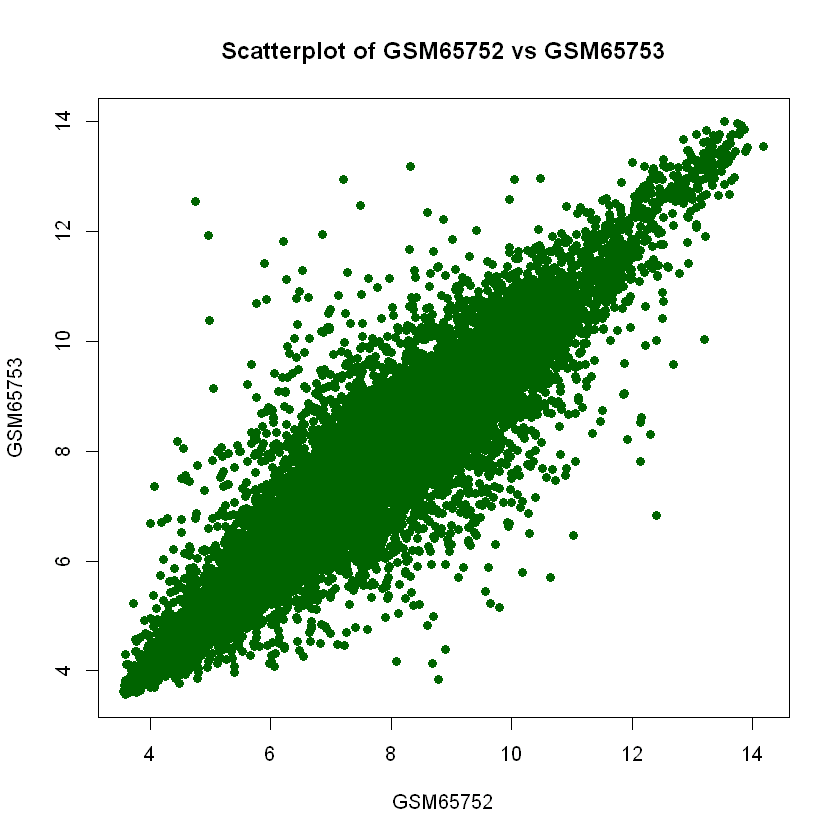

In [112]:
##########################################
# Scatterplots                           #
##########################################

x_col <- colnames(oDataMatrix)[1]
y_col <- colnames(oDataMatrix)[2]

plot(oDataMatrix[, x_col], oDataMatrix[, y_col], main = paste("Scatterplot of", x_col, "vs", y_col),
     xlab = x_col, ylab = y_col, col = "darkgreen", pch = 19)

le package 'Rtsne' a été décompressé et les sommes MD5 ont été vérifiées avec succés

Les packages binaires téléchargés sont dans
	C:\Users\gouro\AppData\Local\Temp\Rtmpie4XYp\downloaded_packages


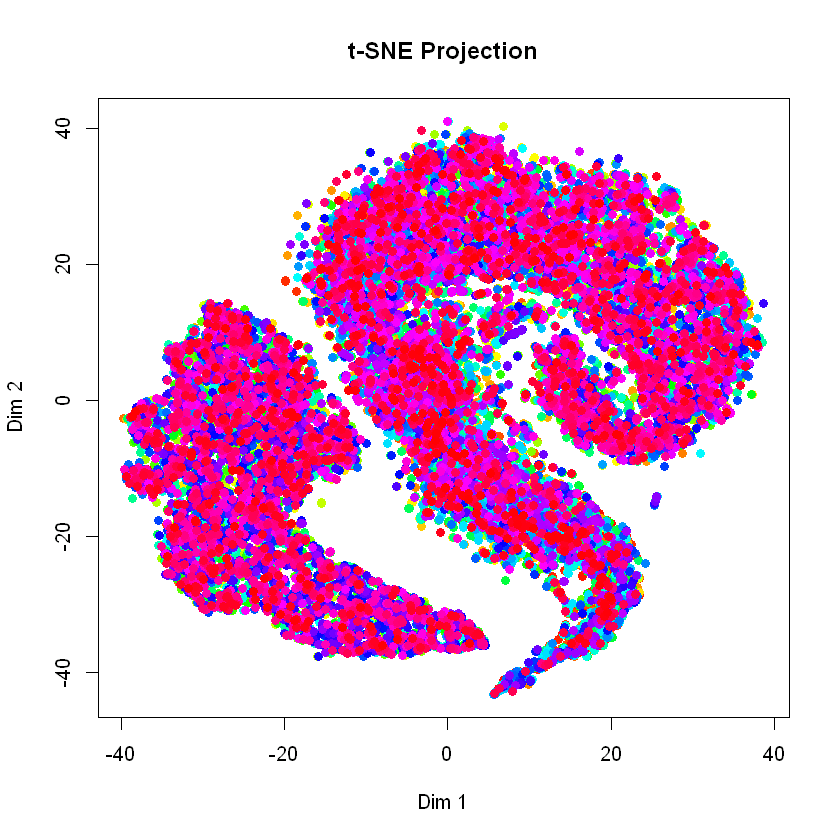

In [91]:
##########################################
# t-SNE Visualization                    #
##########################################

# Reduce dimensionality using t-SNE and visualize clusters.

if (!requireNamespace("Rtsne", quietly = TRUE)) {
    install.packages("Rtsne")
}
library(Rtsne)

# t-SNE
tsne_res <- Rtsne(oDataMatrix, dims = 2, perplexity = 30)

# Visualize t-SNE results
plot(tsne_res$Y, main = "t-SNE Projection", xlab = "Dim 1", ylab = "Dim 2",
     col = rainbow(length(tsne_res$Y[,1])), pch = 19)

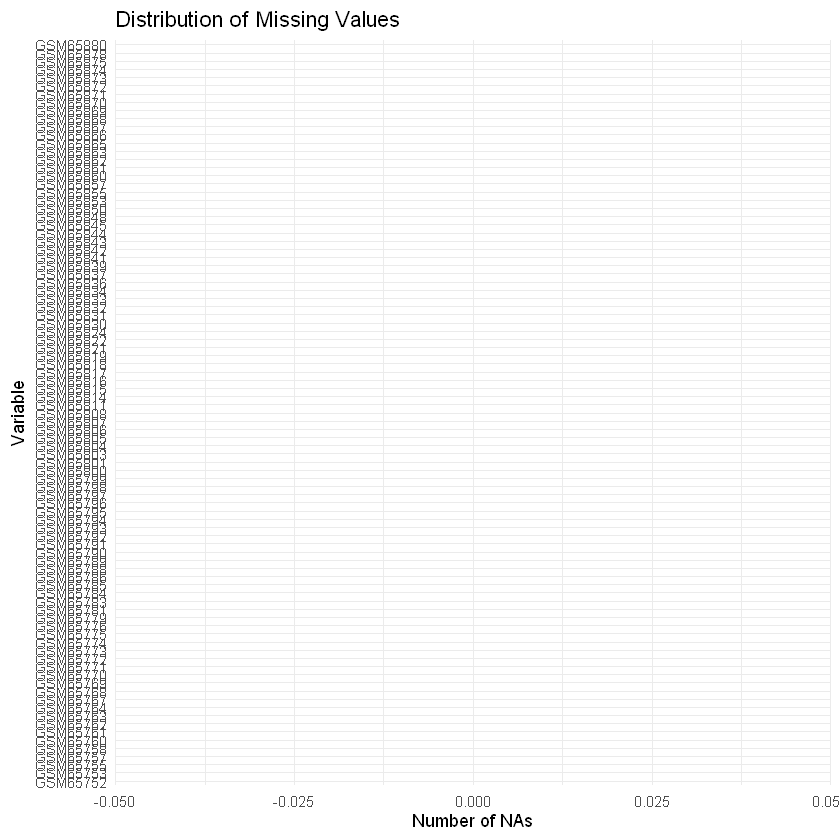

In [93]:
##########################################
# Missing Values                         #
##########################################

library(ggplot2)

# Visualize missing values
na_count <- colSums(is.na(oDataMatrix))
na_df <- data.frame(Variable = names(na_count), NAs = na_count)

ggplot(na_df, aes(x = reorder(Variable, -NAs), y = NAs)) +
    geom_bar(stat = "identity", fill = "salmon") +
    coord_flip() +
    ggtitle("Distribution of Missing Values") +
    theme_minimal() +
    xlab("Variable") +
    ylab("Number of NAs")

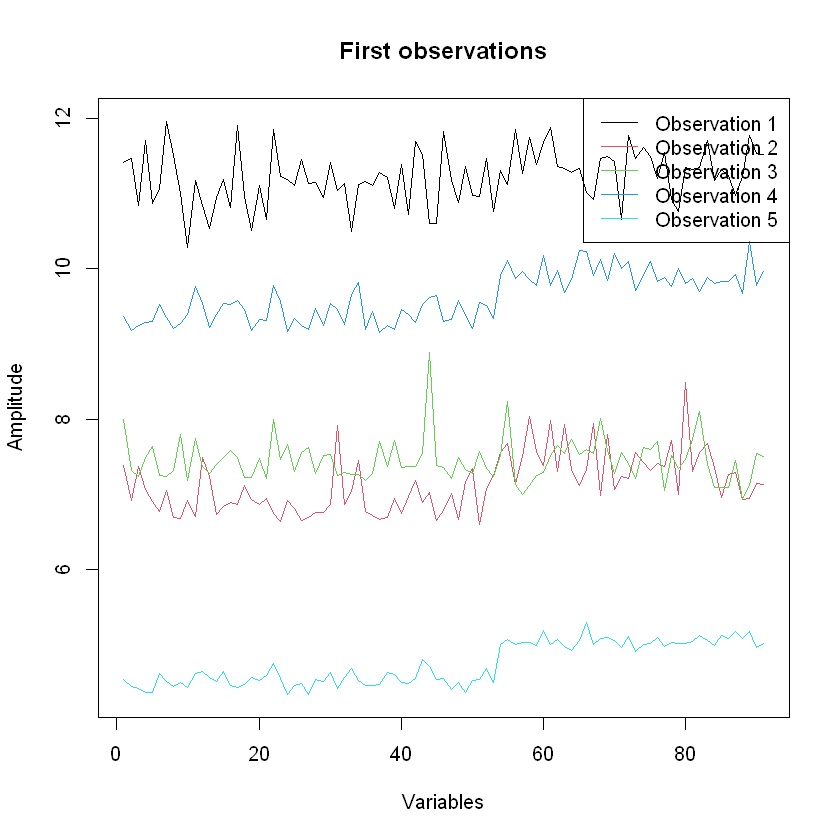

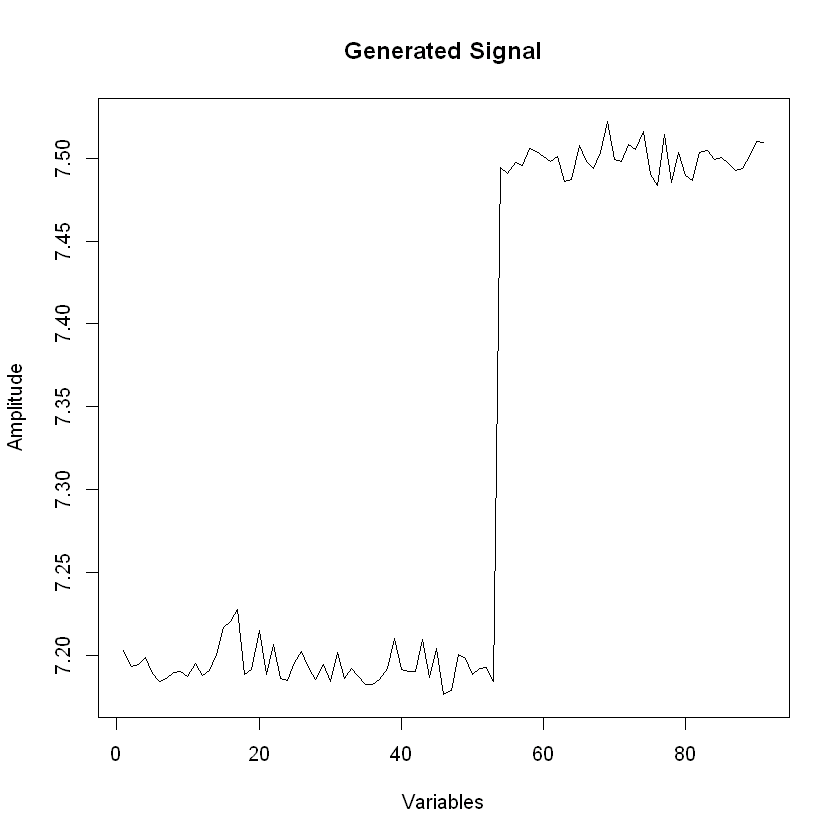

In [95]:
# Ploting first observations             #
##########################################

matplot(t(oDataMatrix[1:5, ]), type = "l", lty = 1, col = 1:5,
        main = "First observations",
        xlab = "Variables", ylab = "Amplitude")
legend("topright", legend = paste("Observation", 1:5), col = 1:5, lty = 1)

# Ploting mean of the generated signal   #
##########################################

mean_signal <- colMeans(oDataMatrix)

plot(mean_signal, type = "l", main = "Generated Signal", xlab = "Variables", ylab = "Amplitude")

In [97]:
Analyze_PCA <- function(X, numAxes = 50, explainedVarianceThreshold = 70) {
  pca <- prcomp(X, center = TRUE, scale. = TRUE)
  
  variance <- (pca$sdev^2 / sum(pca$sdev^2)) * 100
  cat(paste0("Variance explained by the first ", numAxes, " axes: ", sum(variance[1:numAxes]), "\n"))
  
  cum_variance <- cumsum(variance)
  
  num_components <- which(cum_variance >= explainedVarianceThreshold)[1]
  cat(paste("Number of principal components:", num_components, "to have", explainedVarianceThreshold, "% of variance\n"))
  
  d <- data.frame(PCAxes = seq_along(variance), Variance = variance, CumulativeVariance = cum_variance)

  library(ggplot2)
  p1 <- ggplot(d, aes(PCAxes, Variance)) +
    geom_col(fill = "skyblue") +
    labs(title = "Variance Explained by Each Principal Component", 
         x = "Principal Component", y = "Variance (%)") +
    theme_minimal()
  
  p2 <- ggplot(d, aes(PCAxes, CumulativeVariance)) +
    geom_line(color = "blue") +
    geom_point() +
    labs(title = "Cumulative Variance Explained", 
         x = "Principal Component", y = "Cumulative Variance (%)") +
    geom_hline(yintercept = explainedVarianceThreshold, linetype = "dashed", color = "red") +
    annotate("text", x = num_components, y = explainedVarianceThreshold + 5, 
             label = paste("Components:", num_components), color = "red") +
    theme_minimal()
  
  print(p1)
  print(p2)

  return(list(Variance = variance, CumulativeVariance = cum_variance, NumComponents = num_components))
}

Variance explained by the first 15 axes: 97.735898077341
Number of principal components: 1 to have 70 % of variance


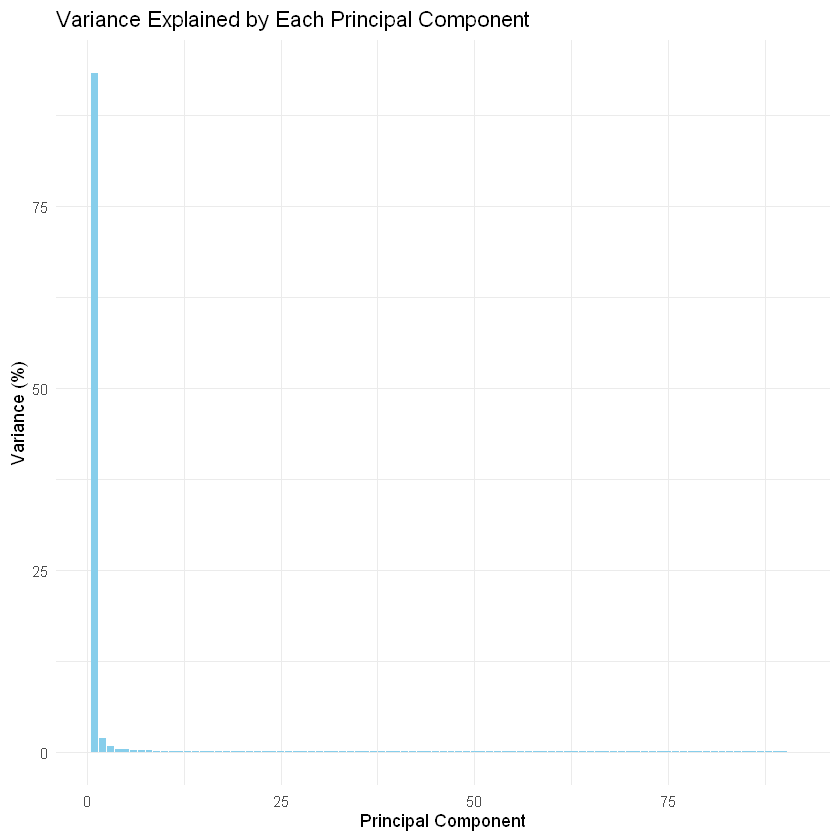

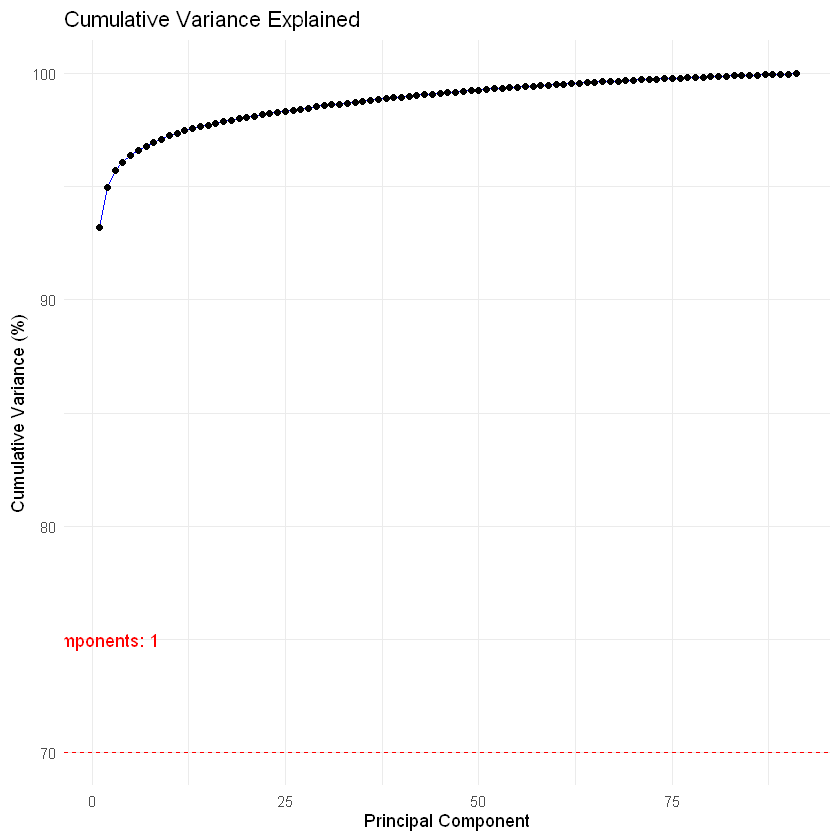

In [114]:
# PCA Exploration                        #
##########################################

oPCAAnalysis <- Analyze_PCA(oDataMatrix, numAxes = 15, explainedVarianceThreshold = 70)

In [116]:
# Create the functions to compute the evaluation criteria

Get_RMSE <- function(rActual, rPredicted) {
  if (length(rActual) != length(rPredicted)) {
    stop("Get_RMSE() - Error : Vectors rActual & rPredicted must have the same lenght.")
  }
  if (any(is.na(rActual)) || any(is.na(rPredicted))) {
    stop("Get_RMSE() - Error : Input data contains NA value(s).")
  }
  return(sqrt(mean((rActual - rPredicted)^2, na.rm = TRUE)))
}

Get_MSE <- function(rActual, rPredicted) {
  if (length(rActual) != length(rPredicted)) {
    stop("Get_MSE() - Error : Vectors rActual & rPredicted must have the same lenght.")
  }
  if (any(is.na(rActual)) || any(is.na(rPredicted))) {
    stop("Get_MSE() - Error : Input data contains NA value(s).")
  }
  return(mean((rActual - rPredicted)^2, na.rm = TRUE))
}

Get_NMSE <- function(rActual, rPredicted) {
  if (length(rActual) != length(rPredicted)) {
    stop("Get_NMSE() - Error : Vectors rActual & rPredicted must have the same lenght.")
  }
  if (any(is.na(rActual)) || any(is.na(rPredicted))) {
    stop("Get_NMSE() - Error : Input data contains NA value(s).")
  }

  rMean_Squared_Error <- sum((rActual - rPredicted)^2)
  rMean_Variance_Error <- sum((rActual - mean(rActual))^2)

  if (rMean_Variance_Error == 0) {
    warning("Get_NMSE() - Error : Division / 0.")
    return(NA)
  }

  return(rMean_Squared_Error / rMean_Variance_Error)
}

# 4. Standard PCA

In [119]:
Perform_Standard_PCA <- function(trainData, testData, numComponents = NULL, varianceThreshold = NULL) {

  selectedCols <- NULL
    
  # Step 1: Select variables based on variance if a threshold is provided
  if (!is.null(varianceThreshold)) {
    colVariances <- apply(trainData, 2, var)  # Calculate variances for each column
    selectedCols <- colVariances > varianceThreshold  # Identify columns with variance above the threshold
    trainData <- trainData[, selectedCols]  # Subset training data
    testData <- testData[, selectedCols]  # Subset test data
  } else {
    selectedCols <- trainData      
  }      
  
  # Step 2: Set number of components to number of columns if not provided
  if (is.null(numComponents)) {
    numComponents <- ncol(trainData)
  }
  
  # Step 3: Perform PCA on training data
  oPcaResult <- prcomp(trainData, center = TRUE, scale. = TRUE)

  plot(oPcaResult$x[, 1:2], main = "Standard PCA", xlab = "PC1", ylab = "PC2")
    
  # Step 4: Project test data onto principal components
  oTestScores <- predict(oPcaResult, newdata = testData)[, 1:numComponents]
  
  # Step 5: Reconstruct test data
  oReconstructedData <- oTestScores %*% t(oPcaResult$rotation[, 1:numComponents])
  oReconstructedData <- scale(oReconstructedData, center = FALSE, scale = 1/oPcaResult$scale)
  oReconstructedData <- sweep(oReconstructedData, 2, oPcaResult$center, "+")

  if (!all(dim(oReconstructedData) == dim(testData))) {
    stop("Mismatch in dimensions between testData and reconstructed data")
  }
    
  # Step 6: Evaluate reconstruction
  dRMSE <- Get_RMSE(as.vector(testData), as.vector(oReconstructedData))
  dMSE <- Get_MSE(as.vector(testData), as.vector(oReconstructedData))
  dNMSE <- Get_NMSE(as.vector(testData), as.vector(oReconstructedData))

  result <- list(RMSE = dRMSE, MSE = dMSE, NMSE = dNMSE)    
  if (!is.null(varianceThreshold)) {
    result$ActiveVariables <- sum(selectedCols)  # Add the count of selected columns if applicable
  } else {
    result$ActiveVariables <- numComponents
  }

  return(result)
}

[1] "Current Time : 2024-12-04 16:38:15"
[1] "Number of Components: 1"
[1] "Standard PCA - RMSE: 0.479764919997054"
[1] "Standard PCA - MSE: 0.23017437845978"
[1] "Standard PCA - NMSE: 0.0672720176262796"
[1] "Current Time : 2024-12-04 16:38:16"
[1] "Standard PCA computation time : 0.809 seconds"


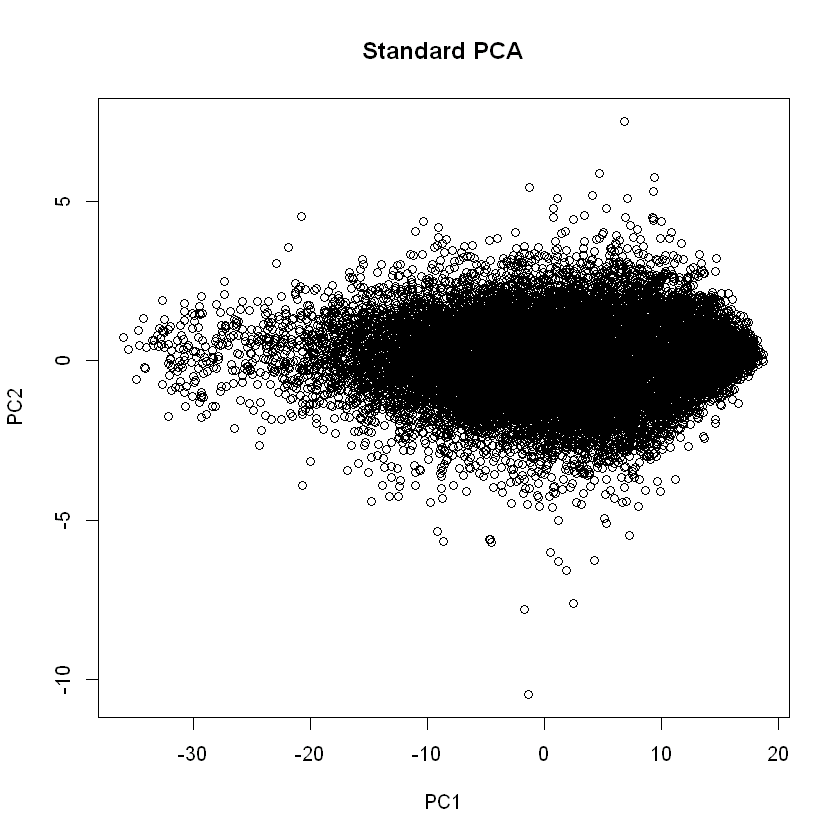

In [121]:
# Standard PCA on the Train DATASET      #
##########################################

# Cell execution time 15/11/2024 : 1.929 seconds

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

# First step => Find the number of components explaining 95% of the variance
oPCAResult <- prcomp(oTrainData, center = TRUE, scale. = TRUE)
dExplained_Variance <- cumsum(oPCAResult$sdev^2) / sum(oPCAResult$sdev^2)
iNumComponents <- which(dExplained_Variance >= 0.80)[1]
print(paste("Number of Components:", iNumComponents))

# Perform Standard PCA
oStandardPCAResults <- Perform_Standard_PCA(oTrainData, oTestData, numComponents = iNumComponents, NULL)

print(paste("Standard PCA - RMSE:", oStandardPCAResults$RMSE))
print(paste("Standard PCA - MSE:", oStandardPCAResults$MSE))
print(paste("Standard PCA - NMSE:", oStandardPCAResults$NMSE))

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Standard PCA computation time :", elapsed_time, "seconds"))

# 5. PCA based on Variance Selection

[1] "Current Time : 2024-12-04 16:40:16"


$RMSE
[1] 0.4797649

$MSE
[1] 0.2301744

$NMSE
[1] 0.06727202

$ActiveVariables
[1] 91

[1] "Current Time : 2024-12-04 16:40:16"
[1] "Variance Selection PCA computation time : 0.483 seconds"


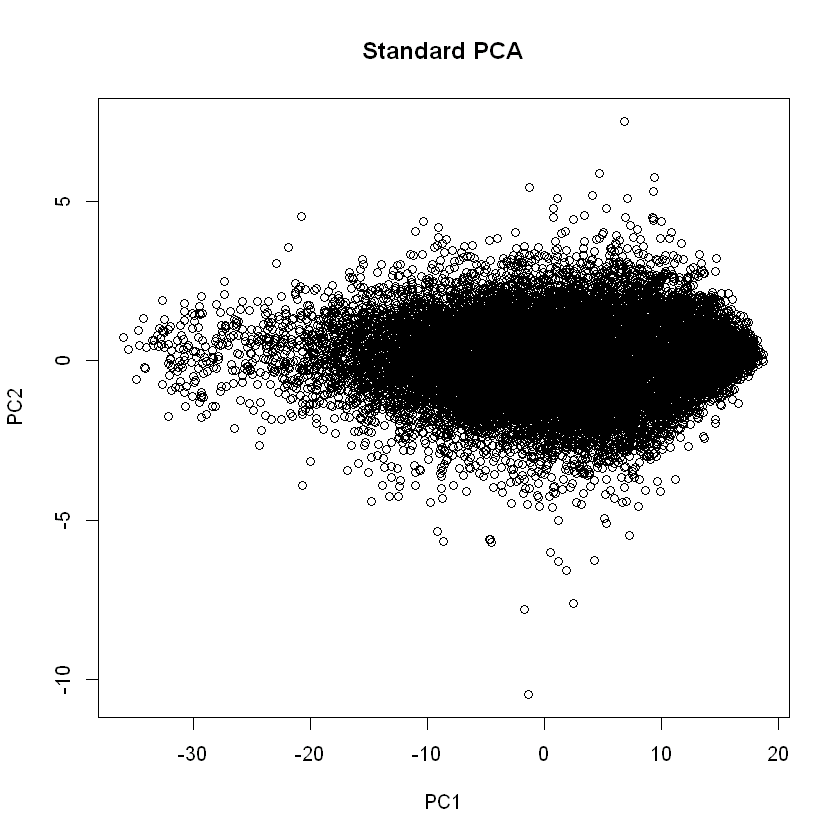

In [126]:
# Variance Selection PCA on the Ytain DATASET      #
####################################################

# Cell execution time 15/11/2024 : 1.929 seconds

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

# Perform Variance Selection PCA
oVarPCAResults <- Perform_Standard_PCA(oTrainData, oTestData, numComponents = iNumComponents, varianceThreshold = 1)

oVarPCAResults

# Display end time and elapsed time
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Variance Selection PCA computation time :", elapsed_time, "seconds"))

# 6. Sparse PCA

In [129]:
Perform_Sparse_PCA <- function(trainData, testData, paraValues, numComponents = 1) {
  library(elasticnet)
  results <- data.frame(Para = paraValues, RMSE = NA, MSE = NA, NMSE = NA, ActiveVariables = NA)
  
  # Parallel execution with exported functions
  results <- foreach(i = 1:length(paraValues), .combine = rbind,
                     .packages = c("elasticnet"), 
                     .export = c("Get_RMSE", "Get_MSE", "Get_NMSE")) %dopar% {
    iPara <- paraValues[i]
    oSparsePcaResult <- spca(trainData, K = numComponents, sparse = "penalty", para = rep(iPara, numComponents))
    
    if (!is.null(oSparsePcaResult$loadings)) {
      oTestScores <- testData %*% oSparsePcaResult$loadings
      oReconstructedData <- oTestScores %*% t(oSparsePcaResult$loadings)
      
      dRMSE <- Get_RMSE(as.vector(testData), as.vector(oReconstructedData))
      dMSE <- Get_MSE(as.vector(testData), as.vector(oReconstructedData))
      dNMSE <- Get_NMSE(as.vector(testData), as.vector(oReconstructedData))
      
      # Nombre de variables actives
      active_vars <- sum(oSparsePcaResult$loadings != 0)
      
      result_row <- data.frame(Para = iPara, RMSE = dRMSE, MSE = dMSE, NMSE = dNMSE, ActiveVariables = active_vars)

      non_zero_loadings <- sum(oSparsePcaResult$loadings != 0)
      cat("Para =", iPara, "- Non-zero loadings:", non_zero_loadings, "\n")
      # Save loadings for further analisys.
      saveRDS(oSparsePcaResult$loadings, file = paste0("loadings_sparse_para_", iPara, ".rds"))
        
      cat("Para =", iPara, "- RMSE:", dRMSE, "- MSE:", dMSE, "- NMSE:", dNMSE, "- Active Variables:", active_vars, "\n")
    } else {
      cat("Para =", iPara, "- No valid loadings returned by spca\n")
      result_row <- data.frame(Para = iPara, RMSE = NA, MSE = NA, NMSE = NA, ActiveVariables = NA)
    }
    
    result_row
  }
  
  return(results)
}

In [131]:
##########################################
# Sparse PCA on the entire Train DATASET #
##########################################

# Cell execution time 15/11/2024 : 355.319 seconds

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

# Penalty list
oParaValues <- c(1, 2, 3, 5, 10, 15, 20, 25, 30)

# Perform Sparse PCA
oSparsePCAResults <- Perform_Sparse_PCA(oTrainData, oTestData, oParaValues, numComponents = 1)

print(oSparsePCAResults)

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Sparse PCA computation time :", elapsed_time, "seconds"))

[1] "Current Time : 2024-12-04 16:40:37"
  Para      RMSE       MSE       NMSE ActiveVariables
1    1 0.5267153 0.2774290 0.08108292              91
2    2 0.5267653 0.2774817 0.08109831              91
3    3 0.5268154 0.2775345 0.08111373              91
4    5 0.5269158 0.2776403 0.08114467              91
5   10 0.5271688 0.2779069 0.08122259              91
6   15 0.5274243 0.2781763 0.08130133              91
7   20 0.5276823 0.2784486 0.08138090              91
8   25 0.5279428 0.2787236 0.08146128              91
9   30 0.5282059 0.2790015 0.08154249              91
[1] "Current Time : 2024-12-04 16:40:49"
[1] "Sparse PCA computation time : 11.812 seconds"


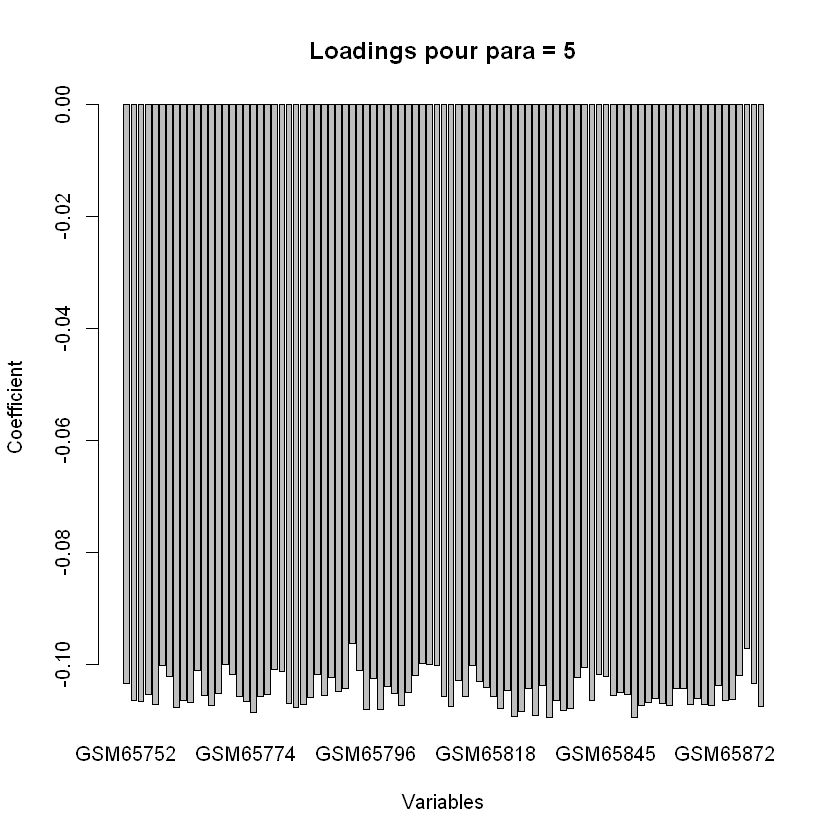

In [132]:
# Visualiser les loadings pour une valeur spécifique de para
iPara <- 5  # Exemple
loadings <- readRDS(paste0("loadings_sparse_para_", iPara, ".rds"))
barplot(loadings[, 1], main = paste("Loadings pour para =", iPara), xlab = "Variables", ylab = "Coefficient")


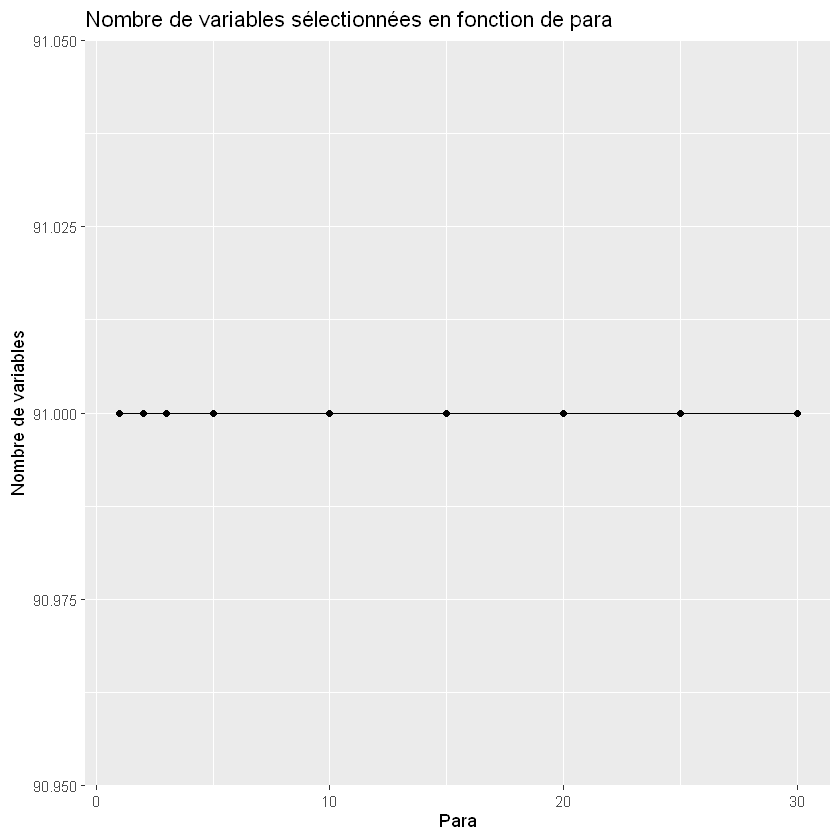

In [134]:
# Après avoir collecté les résultats
ggplot(oSparsePCAResults, aes(x = Para, y = ActiveVariables)) +
  geom_point() +
  geom_line() +
  labs(title = "Nombre de variables sélectionnées en fonction de para", x = "Para", y = "Nombre de variables")




In [140]:
# Sparse PCA : Showing the best result  #
#########################################

# Cell execution time 15/11/2024 : 355.319 seconds

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

library(elasticnet)

variances <- apply(oTrainData, 2, var)

k <- 15  # Nombre de variables à conserver
top_var_indices <- order(variances, decreasing = TRUE)[1:k]
x_reduced <- oTrainData[, top_var_indices]  # Jeu de données réduit

pca_sparse <- prcomp(x_reduced, center = TRUE, scale. = TRUE)


print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Sparse PCA computation time :", elapsed_time, "seconds"))

[1] "Current Time : 2024-12-04 16:41:39"
[1] "Current Time : 2024-12-04 16:41:39"
[1] "Sparse PCA computation time : 0.056 seconds"


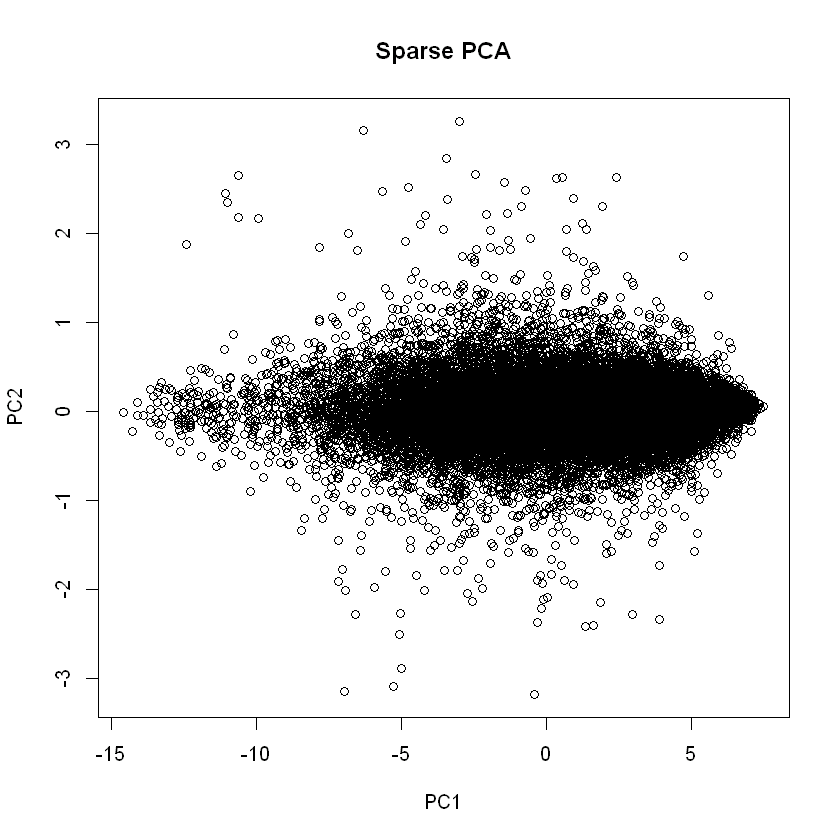

In [142]:

plot(pca_sparse$x[, 1:2], main = "Sparse PCA",
     xlab = "PC1", ylab = "PC2")

# THRESHOLD PCA

In [145]:
Perform_Threshold_PCA <- function(trainData, testData, thresholdValues, numComponents = 1) {
  results <- data.frame(Threshold = thresholdValues, RMSE = NA, MSE = NA, NMSE = NA)
  
  # Parallel execution with exported functions
  results <- foreach(i = 1:length(thresholdValues), .combine = rbind, 
                     .packages = c("stats"), 
                     .export = c("Get_RMSE", "Get_MSE", "Get_NMSE")) %dopar% {
    dThreshold <- thresholdValues[i]
    
    # Selecting variables with variance above the threshold
    oVariances <- apply(trainData, 2, var)
    oSelectedIndices <- which(oVariances > dThreshold)
    
    if (length(oSelectedIndices) > 0) {
      # Applying PCA on the selected subset of variables
      oTrainDataSelected <- trainData[, oSelectedIndices, drop = FALSE]
      oTestDataSelected <- testData[, oSelectedIndices, drop = FALSE]
      
      oPcaResult <- prcomp(oTrainDataSelected, center = TRUE, scale. = TRUE)
      
      # Project test data
      oTestScores <- predict(oPcaResult, newdata = oTestDataSelected)[, 1:numComponents, drop = FALSE]
      
      # Reconstruct test data
      oReconstructedData <- oTestScores %*% t(oPcaResult$rotation[, 1:numComponents, drop = FALSE])
      oReconstructedData <- scale(oReconstructedData, center = FALSE, scale = 1 / oPcaResult$scale)
      oReconstructedData <- sweep(oReconstructedData, 2, oPcaResult$center, "+")
      
      # Expand reconstructed data to original dimensions
      oReconstructedFull <- matrix(0, nrow = nrow(testData), ncol = ncol(testData))
      oReconstructedFull[, oSelectedIndices] <- oReconstructedData
      
      # Evaluate
      dRMSE <- Get_RMSE(as.vector(testData), as.vector(oReconstructedFull))
      dMSE <- Get_MSE(as.vector(testData), as.vector(oReconstructedFull))
      dNMSE <- Get_NMSE(as.vector(testData), as.vector(oReconstructedFull))
      
      # Store results
      result_row <- data.frame(Threshold = dThreshold, RMSE = dRMSE, MSE = dMSE, NMSE = dNMSE)
      
      cat("Threshold =", dThreshold, "- RMSE:", dRMSE, "- MSE:", dMSE, "- NMSE:", dNMSE, "\n")
    } else {
      cat("Threshold =", dThreshold, "- No variables selected\n")
      result_row <- data.frame(Threshold = dThreshold, RMSE = NA, MSE = NA, NMSE = NA)
    }
    
    result_row
  }
  
  return(results)
}

In [147]:
# Threshold PCA on the entire DATASET 01   #
############################################

# Cell execution time 15/11/2024 : 13.563 seconds

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

# Threshold list
thresholdValues <- seq(0.05, 1, by = 0.05)

# Perform Threshold PCA
oThresholdPCAResults <- Perform_Threshold_PCA(oTrainData, oTestData, thresholdValues, numComponents = 1)

print(oThresholdPCAResults)

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Threshold PCA computation time :", elapsed_time, "seconds"))

[1] "Current Time : 2024-12-04 16:42:04"
   Threshold      RMSE       MSE       NMSE
1       0.05 0.4797649 0.2301744 0.06727202
2       0.10 0.4797649 0.2301744 0.06727202
3       0.15 0.4797649 0.2301744 0.06727202
4       0.20 0.4797649 0.2301744 0.06727202
5       0.25 0.4797649 0.2301744 0.06727202
6       0.30 0.4797649 0.2301744 0.06727202
7       0.35 0.4797649 0.2301744 0.06727202
8       0.40 0.4797649 0.2301744 0.06727202
9       0.45 0.4797649 0.2301744 0.06727202
10      0.50 0.4797649 0.2301744 0.06727202
11      0.55 0.4797649 0.2301744 0.06727202
12      0.60 0.4797649 0.2301744 0.06727202
13      0.65 0.4797649 0.2301744 0.06727202
14      0.70 0.4797649 0.2301744 0.06727202
15      0.75 0.4797649 0.2301744 0.06727202
16      0.80 0.4797649 0.2301744 0.06727202
17      0.85 0.4797649 0.2301744 0.06727202
18      0.90 0.4797649 0.2301744 0.06727202
19      0.95 0.4797649 0.2301744 0.06727202
20      1.00 0.4797649 0.2301744 0.06727202
[1] "Current Time : 2024-12-04 16:4

# 7. RESULTS

In [149]:
# Merging results array                 #
#########################################

library(reshape2)
library(tidyr)

# Convert named lists to numeric values
oStandardPCAResults$RMSE <- as.numeric(oStandardPCAResults$RMSE)
oStandardPCAResults$MSE <- as.numeric(oStandardPCAResults$MSE)
oStandardPCAResults$NMSE <- as.numeric(oStandardPCAResults$NMSE)
oSparsePCAResults$RMSE <- sapply(oSparsePCAResults$RMSE, as.numeric)
oSparsePCAResults$MSE <- sapply(oSparsePCAResults$MSE, as.numeric)
oSparsePCAResults$NMSE <- sapply(oSparsePCAResults$NMSE, as.numeric)
oThresholdPCAResults$RMSE <- sapply(oThresholdPCAResults$RMSE, as.numeric)
oThresholdPCAResults$MSE <- sapply(oThresholdPCAResults$MSE, as.numeric)
oThresholdPCAResults$NMSE <- sapply(oThresholdPCAResults$NMSE, as.numeric)

# New data frames
standardPCAResultsDF <- data.frame(Method = "Standard PCA", Parameter = 0, 
                                   RMSE = oStandardPCAResults$RMSE, 
                                   MSE = oStandardPCAResults$MSE, 
                                   NMSE = oStandardPCAResults$NMSE)

sparsePCAResultsDF <- data.frame(Method = "Sparse PCA", Parameter = oSparsePCAResults$Para, 
                                 RMSE = unlist(oSparsePCAResults$RMSE), 
                                 MSE = unlist(oSparsePCAResults$MSE), 
                                 NMSE = unlist(oSparsePCAResults$NMSE))

thresholdPCAResultsDF <- data.frame(Method = "Threshold PCA", Parameter = oThresholdPCAResults$Threshold, 
                                    RMSE = unlist(oThresholdPCAResults$RMSE), 
                                    MSE = unlist(oThresholdPCAResults$MSE), 
                                    NMSE = unlist(oThresholdPCAResults$NMSE))

# Combine all results
allResults <- rbind(standardPCAResultsDF, sparsePCAResultsDF, thresholdPCAResultsDF)
# Cleaning
allResults$Parameter <- replace_na(allResults$Parameter, 0)

allResults <- allResults %>%
  mutate(Global_Score = (RMSE + MSE + NMSE) / 3)

print(allResults)

          Method Parameter      RMSE       MSE       NMSE Global_Score
1   Standard PCA      0.00 0.4797649 0.2301744 0.06727202    0.2590704
2     Sparse PCA      1.00 0.5267153 0.2774290 0.08108292    0.2950758
3     Sparse PCA      2.00 0.5267653 0.2774817 0.08109831    0.2951151
4     Sparse PCA      3.00 0.5268154 0.2775345 0.08111373    0.2951545
5     Sparse PCA      5.00 0.5269158 0.2776403 0.08114467    0.2952336
6     Sparse PCA     10.00 0.5271688 0.2779069 0.08122259    0.2954328
7     Sparse PCA     15.00 0.5274243 0.2781763 0.08130133    0.2956340
8     Sparse PCA     20.00 0.5276823 0.2784486 0.08138090    0.2958372
9     Sparse PCA     25.00 0.5279428 0.2787236 0.08146128    0.2960426
10    Sparse PCA     30.00 0.5282059 0.2790015 0.08154249    0.2962499
11 Threshold PCA      0.05 0.4797649 0.2301744 0.06727202    0.2590704
12 Threshold PCA      0.10 0.4797649 0.2301744 0.06727202    0.2590704
13 Threshold PCA      0.15 0.4797649 0.2301744 0.06727202    0.2590704
14 Thr

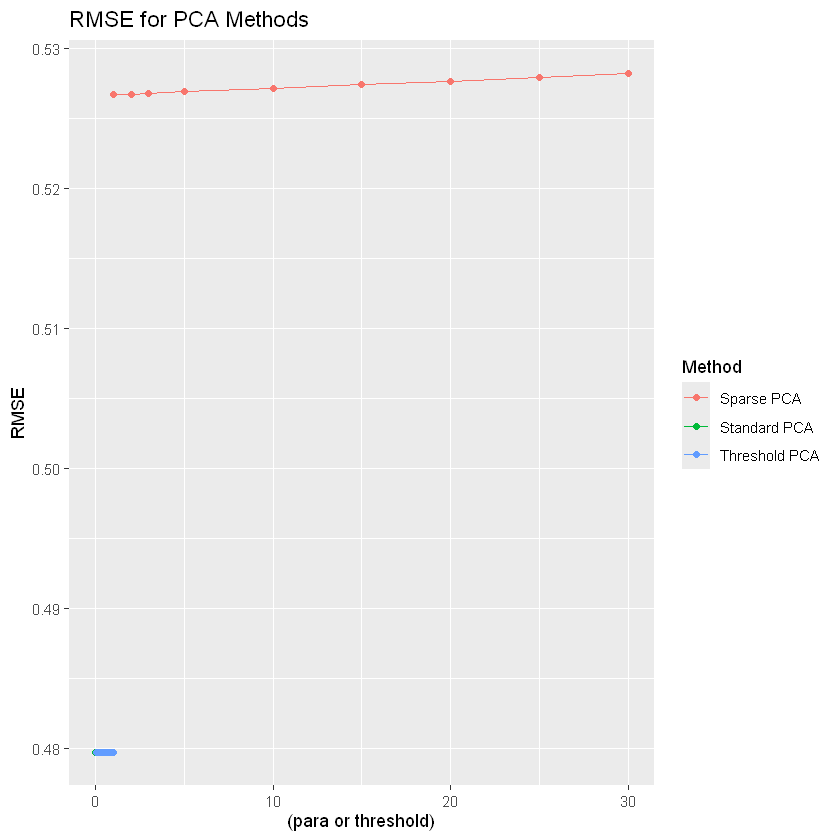

In [151]:
ggplot(allResults, aes(x = Parameter, y = RMSE, color = Method)) +
  geom_point() +
  geom_line() +
  labs(title = "RMSE for PCA Methods", x = "(para or threshold)", y = "RMSE")

In [153]:
# Computing a score                     #
#########################################

summaryDF <- allResults %>%
  group_by(Method) %>%
  summarise(
    Mean_RMSE = mean(RMSE),
    Mean_MSE = mean(MSE),
    Mean_NMSE = mean(NMSE)
  )

summaryDF <- summaryDF %>%
  mutate(Global_Score = (Mean_RMSE + Mean_MSE + Mean_NMSE) / 3)

print(summaryDF %>% arrange(Global_Score))  # Sorted by best global score...

# A tibble: 3 × 5
  Method        Mean_RMSE Mean_MSE Mean_NMSE Global_Score
  <chr>             <dbl>    <dbl>     <dbl>        <dbl>
1 Standard PCA      0.480    0.230    0.0673        0.259
2 Threshold PCA     0.480    0.230    0.0673        0.259
3 Sparse PCA        0.527    0.278    0.0813        0.296


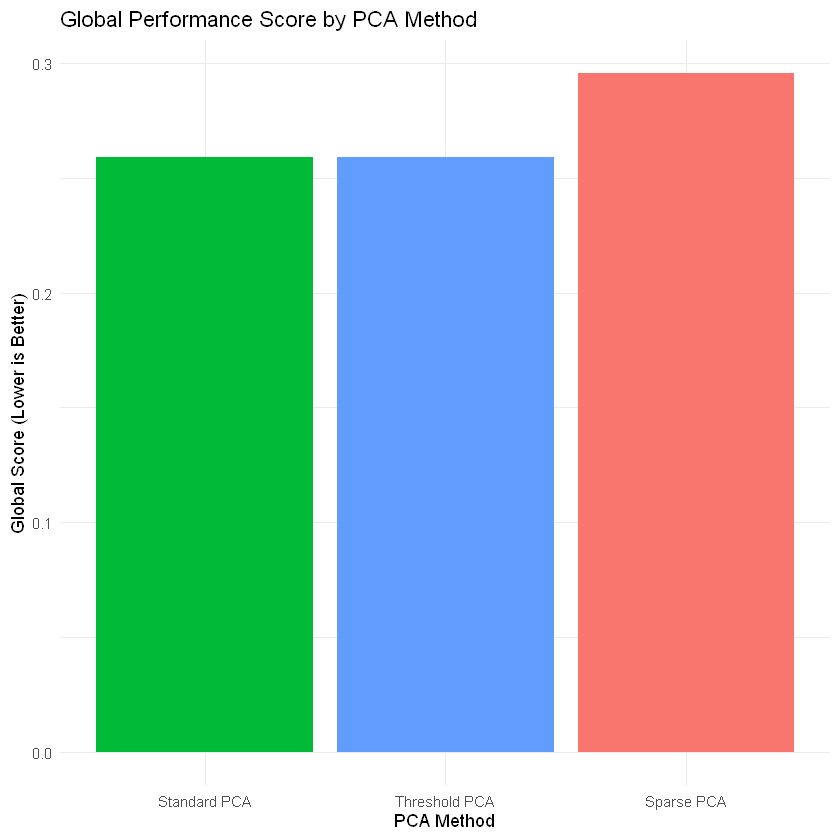

In [155]:
library(ggplot2)

ggplot(summaryDF, aes(x = reorder(Method, Global_Score), y = Global_Score, fill = Method)) +
  geom_bar(stat = "identity") +
  labs(title = "Global Performance Score by PCA Method",
       x = "PCA Method",
       y = "Global Score (Lower is Better)") +
  theme_minimal() +
  theme(legend.position = "none")

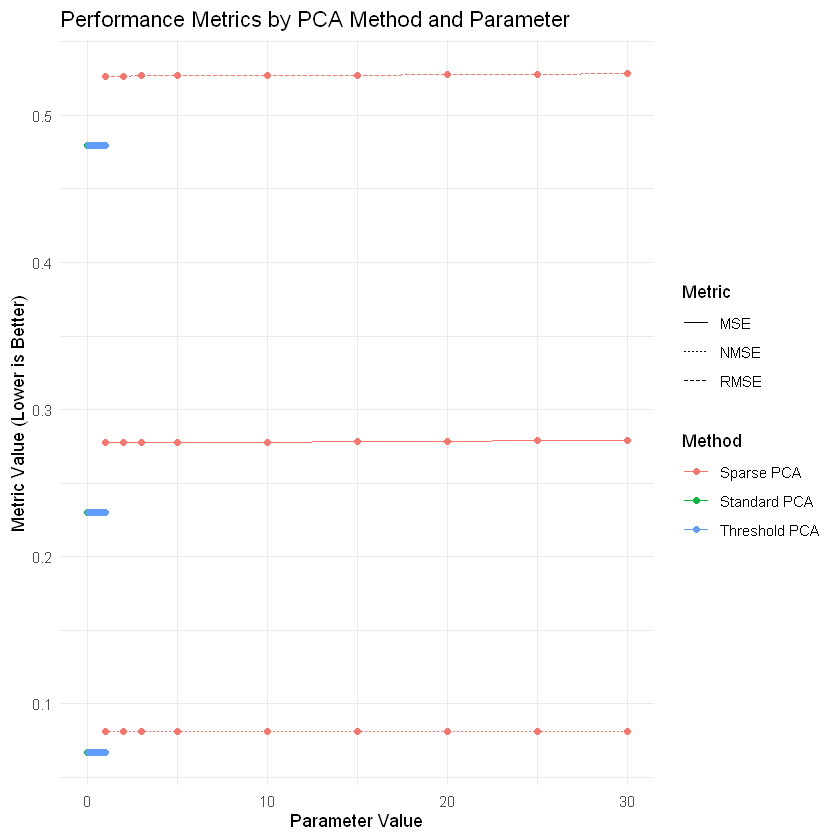

In [157]:
library(tidyr)

allResultsLong <- allResults %>%
  pivot_longer(cols = c("RMSE", "MSE", "NMSE"), names_to = "Metric", values_to = "Value")

ggplot(allResultsLong, aes(x = Parameter, y = Value, color = Method)) +
  geom_line(aes(linetype = Metric)) +
  geom_point() +
  labs(title = "Performance Metrics by PCA Method and Parameter",
       x = "Parameter Value",
       y = "Metric Value (Lower is Better)") +
  theme_minimal()

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


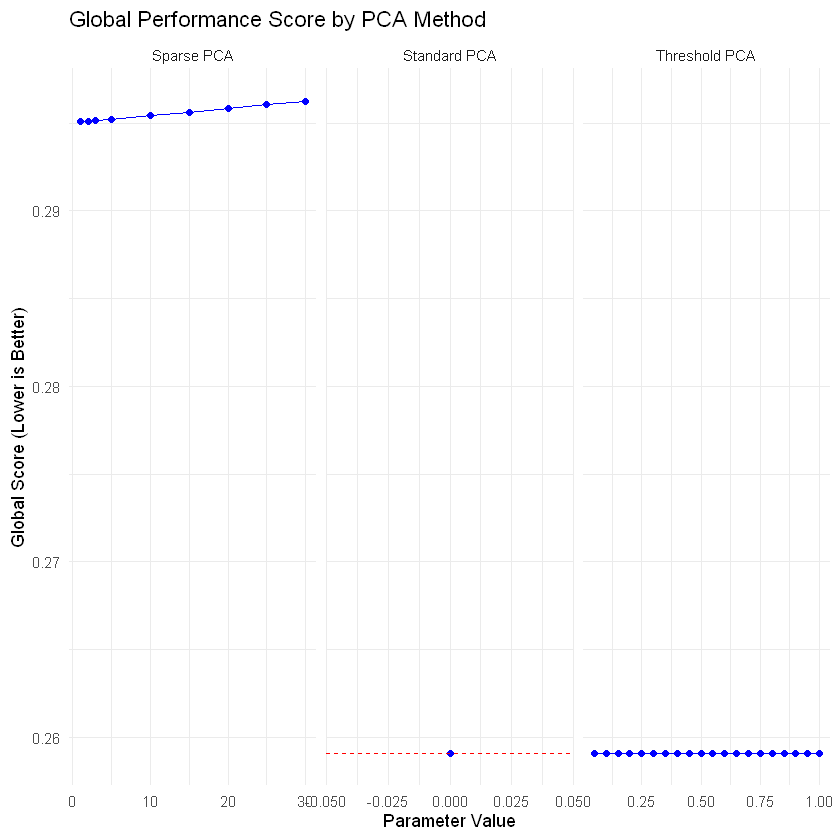

In [159]:
library(dplyr)
library(ggplot2)

# Compute vertical scale
global_min <- min(allResults$Global_Score, na.rm = TRUE)
global_max <- max(allResults$Global_Score, na.rm = TRUE)

ggplot(allResults, aes(x = Parameter, y = Global_Score)) +
  geom_line(aes(group = Method), color = "blue") +
  geom_point(color = "blue") +
  geom_hline(data = allResults %>% filter(Method == "Standard PCA"),
             aes(yintercept = Global_Score), linetype = "dashed", color = "red") +
  facet_wrap(~ Method, scales = "free_x") +
  labs(title = "Global Performance Score by PCA Method",
       x = "Parameter Value",
       y = "Global Score (Lower is Better)") +
  theme_minimal() +
  coord_cartesian(ylim = c(global_min, global_max))


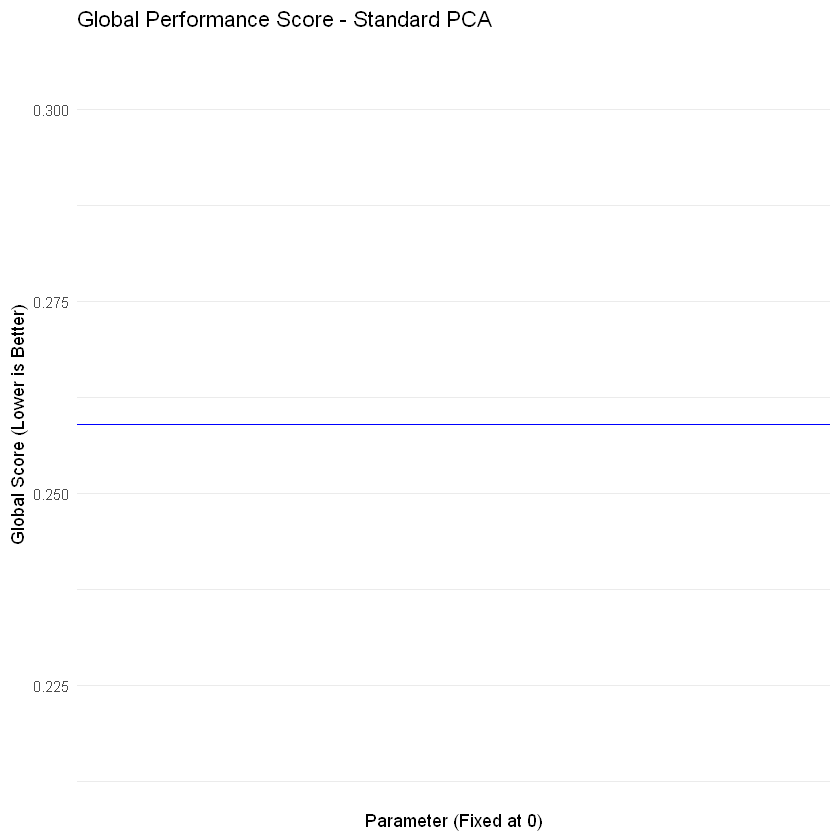

In [161]:
# Standard PCA
standardPCA <- allResults %>% filter(Method == "Standard PCA")

ggplot(standardPCA, aes(x = Parameter, y = Global_Score)) +
  geom_hline(aes(yintercept = Global_Score), color = "blue") +
  labs(title = "Global Performance Score - Standard PCA",
       x = "Parameter (Fixed at 0)",
       y = "Global Score (Lower is Better)") +
  theme_minimal()

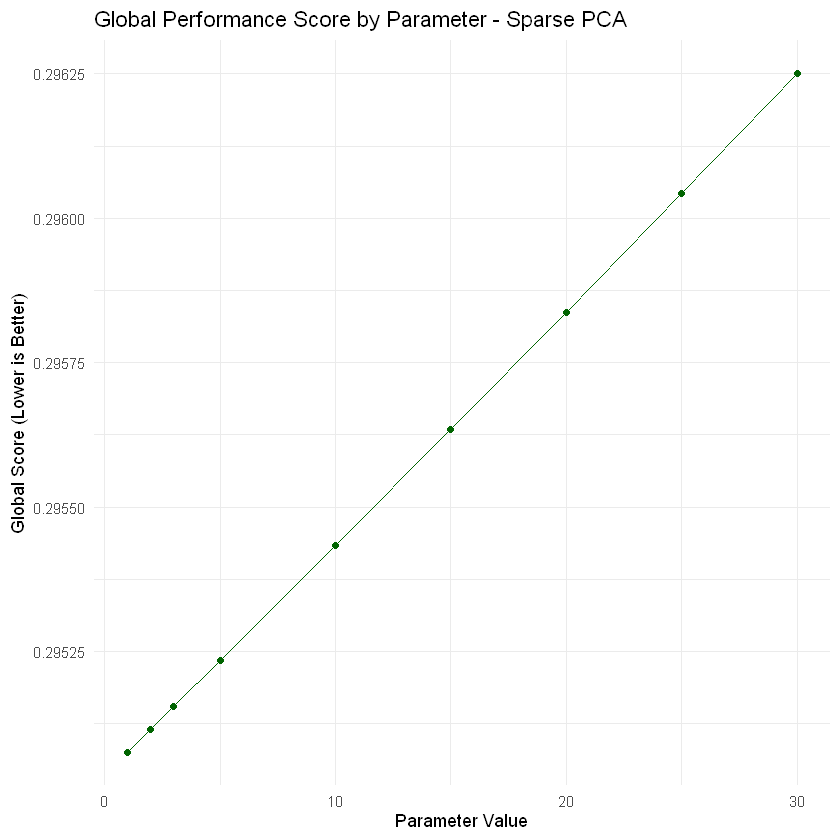

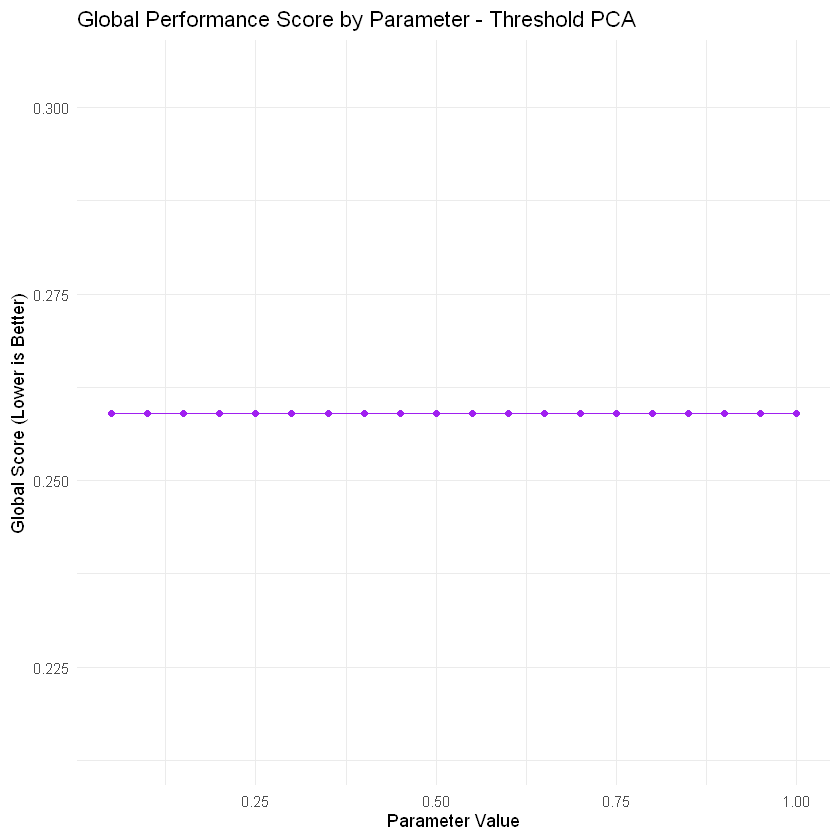

In [163]:
# Sparse PCA
sparsePCA <- allResults %>% filter(Method == "Sparse PCA")
ggplot(sparsePCA, aes(x = Parameter, y = Global_Score)) +
  geom_line(color = "darkgreen") +
  geom_point(color = "darkgreen") +
  labs(title = "Global Performance Score by Parameter - Sparse PCA",
       x = "Parameter Value",
       y = "Global Score (Lower is Better)") +
  theme_minimal()

# Threshold PCA
thresholdPCA <- allResults %>% filter(Method == "Threshold PCA")
ggplot(thresholdPCA, aes(x = Parameter, y = Global_Score)) +
  geom_line(color = "purple") +
  geom_point(color = "purple") +
  labs(title = "Global Performance Score by Parameter - Threshold PCA",
       x = "Parameter Value",
       y = "Global Score (Lower is Better)") +
  theme_minimal()